# Capstone Project: Predicting High-Risk Drought Zones in Sri Lanka

**Src**: [NASA POWER Data Access Viewer](https://power.larc.nasa.gov/data-access-viewer/)

---

## 🧠 Problem Formulation

### 📌 Research Question:
Can we identify and predict high-risk drought zones in Sri Lanka using climate and satellite data, and how can this inform better water management and agricultural planning?

### ✅ Justification:
Droughts in Sri Lanka severely impact agriculture, water availability, and rural livelihoods. Early identification of drought-prone zones can support:
- Improved resource allocation
- Targeted drought mitigation strategies
- Sustainable agricultural planning
- Evidence-based policy decisions

This aligns directly with **IWMI’s** mission of promoting sustainable water management and enhancing climate resilience in vulnerable regions.


In [31]:
!pip install geopandas folium geopy xgboost shap tensorflow

In [32]:
import pandas as pd         # for data handling
import numpy as np          # for numerical computations
# 📈 Visualization
import matplotlib.pyplot as plt      # for plotting
import seaborn as sns               # for statistical visualizations
import plotly.express as px         # for interactive maps and plots
# 📊 Geospatial Mapping
import geopandas as gpd             # for shapefiles and geo data
import folium                       # for interactive maps
import geopy                        # for geocoding, distance, etc.
# 📚 Machine Learning / Prediction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb               # gradient boosting
# 🔍 Time Series / Trend Analysis
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# 📂 System/Utility
import os
import glob                         # to read multiple CSVs if needed

# Import the All Data files 

In [33]:
# Get a list of all CSV files in the 'data' directory
csv_files = glob.glob(os.path.join("data", "*.csv"))  # remove leading '/' unless it's an absolute path

# Create an empty list to store DataFrames
all_df = []

# Iterate through the list of files
for csv_file in csv_files:
    # Skip first 9 rows (NASA POWER metadata)
    df = pd.read_csv(csv_file, skiprows=9)
    all_df.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(all_df, ignore_index=True)

# Display the combined DataFrame
print(combined_df.head())

           PARAMETER  YEAR  LAT   LON    JAN    FEB    MAR    APR    MAY  \
0  CLRSKY_SFC_SW_DWN  2010  6.5  79.5  22.75  24.40  25.35  25.65  24.59   
1  CLRSKY_SFC_SW_DWN  2010  6.5  80.5  23.04  24.85  25.96  26.17  25.14   
2  CLRSKY_SFC_SW_DWN  2010  6.5  81.5  22.71  24.50  25.69  25.87  24.80   
3  CLRSKY_SFC_SW_DWN  2010  7.5  79.5  22.37  24.18  25.37  25.73  24.79   
4  CLRSKY_SFC_SW_DWN  2010  7.5  80.5  22.70  24.65  25.95  26.24  25.36   

     JUN    JUL    AUG    SEP    OCT    NOV    DEC    ANN  
0  23.90  24.26  24.97  25.34  24.74  22.70  22.14  24.23  
1  24.44  24.83  25.39  25.64  25.14  23.28  22.56  24.71  
2  24.08  24.50  25.02  25.30  24.79  22.95  22.25  24.37  
3  24.15  24.48  25.06  25.29  24.47  22.39  21.71  24.16  
4  24.66  25.02  25.46  25.59  24.89  22.93  22.13  24.63  


In [34]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23940 entries, 0 to 23939
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PARAMETER  23940 non-null  object 
 1   YEAR       23940 non-null  int64  
 2   LAT        23940 non-null  float64
 3   LON        23940 non-null  float64
 4   JAN        23684 non-null  float64
 5   FEB        23684 non-null  float64
 6   MAR        22350 non-null  float64
 7   APR        22350 non-null  float64
 8   MAY        22350 non-null  float64
 9   JUN        22350 non-null  float64
 10  JUL        22194 non-null  float64
 11  AUG        22194 non-null  float64
 12  SEP        22194 non-null  float64
 13  OCT        22194 non-null  float64
 14  NOV        22194 non-null  float64
 15  DEC        22194 non-null  float64
 16  ANN        22194 non-null  float64
dtypes: float64(15), int64(1), object(1)
memory usage: 3.1+ MB


In [35]:
lethofparameter=combined_df["PARAMETER"].unique()
print(len(lethofparameter))
print(lethofparameter)

38
['CLRSKY_SFC_SW_DWN' 'ALLSKY_SFC_UVB' 'ALLSKY_SFC_UV_INDEX' 'T2M' 'T2MDEW'
 'T2MWET' 'TS' 'T2M_RANGE' 'T2M_MAX' 'T2M_MIN' 'ALLSKY_SFC_LW_DWN'
 'ALLSKY_SFC_SW_DNI' 'QV2M' 'RH2M' 'PRECTOTCORR' 'PRECTOTCORR_SUM' 'PS'
 'WS2M' 'WS2M_MAX' 'WS2M_MIN' 'WS2M_RANGE' 'WD2M' 'ALLSKY_SFC_SW_DIFF'
 'WS10M' 'WS10M_MAX' 'WS10M_MIN' 'WS10M_RANGE' 'WD10M' 'GWETTOP'
 'GWETROOT' 'GWETPROF' 'ALLSKY_SRF_ALB' 'TOA_SW_DWN' 'CLOUD_AMT'
 'ALLSKY_SFC_PAR_TOT' 'CLRSKY_SFC_PAR_TOT' 'ALLSKY_SFC_UVA'
 'ALLSKY_SFC_SW_DWN']


In [36]:
combined_df.describe()

,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN
count,23940.000000,23940.00000,23940.000000,23684.000000,23684.000000,22350.000000,22350.000000,22350.000000,22350.000000,22194.000000,22194.000000,22194.000000,22194.000000,22194.000000,22194.000000,22194.000000
mean,2017.451128,8.00000,80.330827,23.132147,22.606498,25.855426,34.662536,40.278683,37.476999,37.617667,38.134421,38.980987,42.744918,37.347098,30.151496,93.833072
std,4.584803,1.27515,1.047029,37.204607,30.784448,38.182528,55.799801,67.886659,63.468630,64.453904,64.086515,65.318320,76.558317,76.313370,61.583281,329.966813
min,2010.000000,6.00000,78.750000,0.010000,0.000000,0.000000,0.000000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000
25%,2013.000000,7.00000,79.375000,3.430000,3.170000,2.680000,2.860000,4.170000,4.210000,3.980000,4.070000,4.140000,3.810000,3.640000,3.860000,4.590000
50%,2017.000000,8.00000,80.500000,10.515000,10.785000,10.815000,10.955000,11.935000,11.440000,11.560000,11.620000,11.580000,11.530000,12.330000,11.465000,14.530000
75%,2021.000000,9.00000,81.250000,26.870000,27.450000,28.800000,30.210000,30.020000,29.200000,28.910000,28.930000,28.910000,28.830000,28.040000,27.290000,28.930000
max,2025.000000,10.00000,81.875000,823.980000,500.140000,359.700000,440.090000,674.650000,313.310000,276.400000,283.460000,522.250000,774.970000,723.600000,978.410000,3391.900000


In [37]:
combined_df.isna().sum()

PARAMETER       0
YEAR            0
LAT             0
LON             0
JAN           256
FEB           256
MAR          1590
APR          1590
MAY          1590
JUN          1590
JUL          1746
AUG          1746
SEP          1746
OCT          1746
NOV          1746
DEC          1746
ANN          1746
dtype: int64

In [38]:
combined_df.fillna(combined_df.groupby("PARAMETER").transform("mean"), inplace=True)

In [39]:
combined_df.isna().sum()

PARAMETER    0
YEAR         0
LAT          0
LON          0
JAN          0
FEB          0
MAR          0
APR          0
MAY          0
JUN          0
JUL          0
AUG          0
SEP          0
OCT          0
NOV          0
DEC          0
ANN          0
dtype: int64

# Exploratory Data Analysis (EDA)

## Basic Parameter Distribution

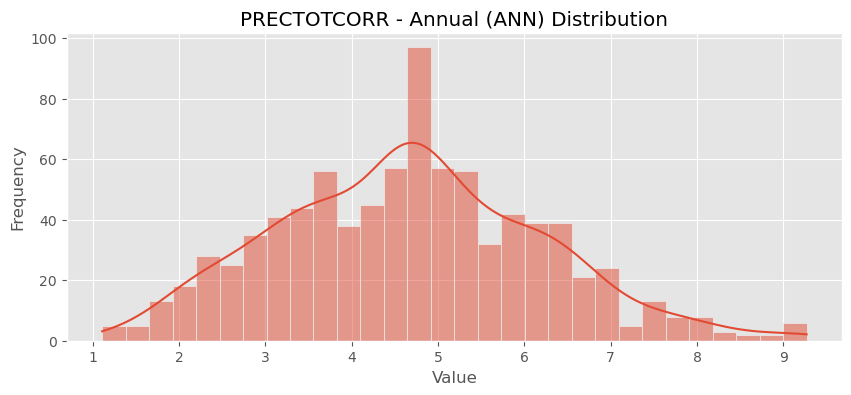

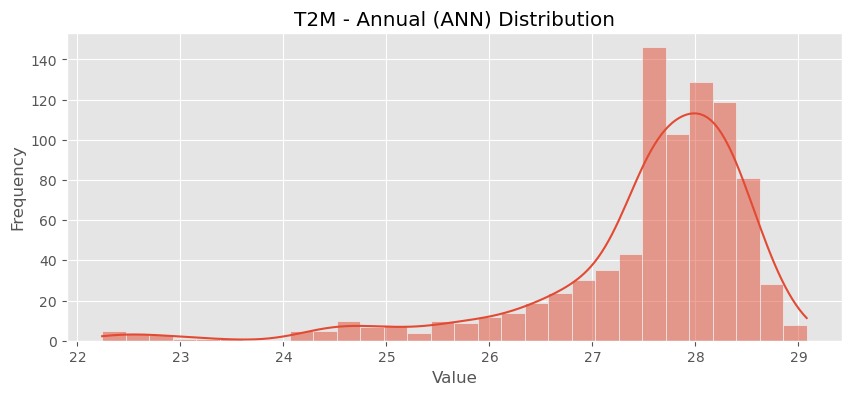

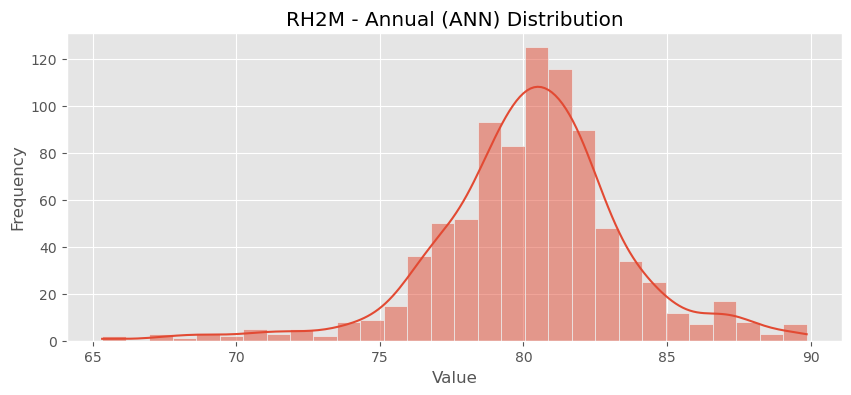

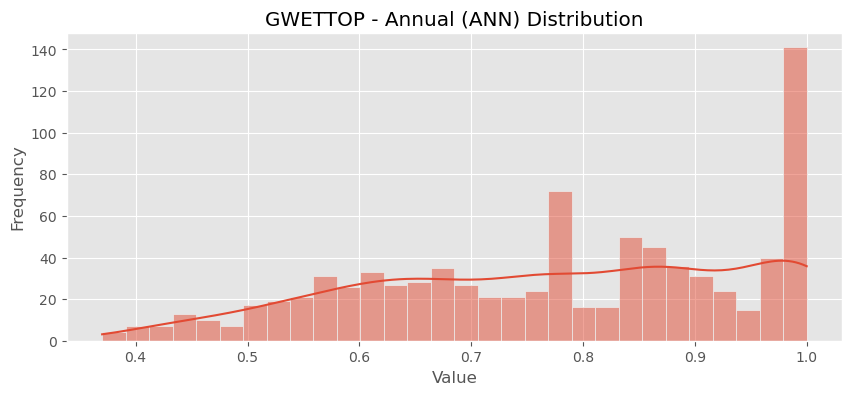

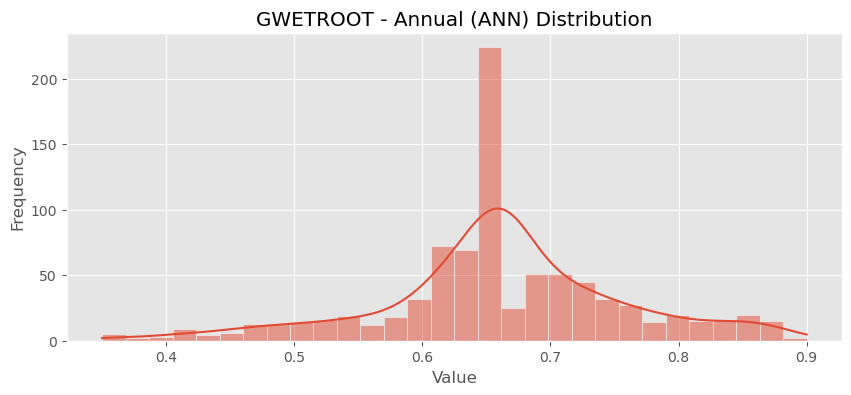

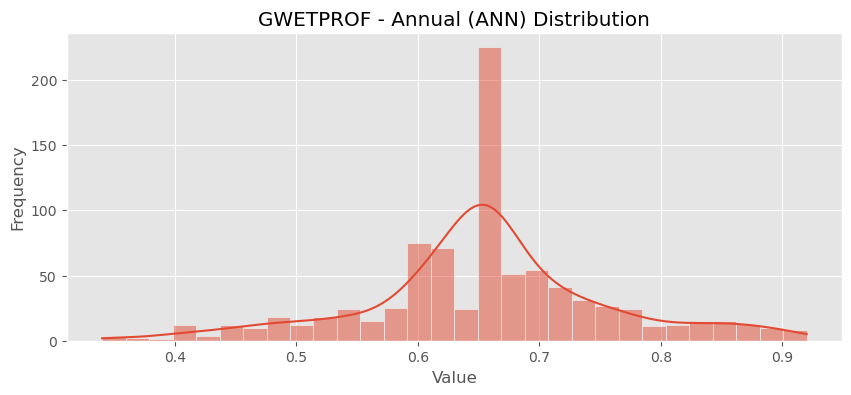

In [40]:
# Plot distribution of some key parameters
key_params = ['PRECTOTCORR', 'T2M', 'RH2M', 'GWETTOP', 'GWETROOT', 'GWETPROF']

for param in key_params:
    if param in combined_df['PARAMETER'].unique():
        subset = combined_df[combined_df['PARAMETER'] == param]
        plt.figure(figsize=(10, 4))
        sns.histplot(subset['ANN'], kde=True, bins=30)
        plt.title(f'{param} - Annual (ANN) Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

## Basic Parameter Distribution Analysis

### Understanding Key Climate Indicators

The distribution analysis of our six key parameters provides crucial insights into Sri Lanka's climate patterns and potential drought vulnerability:

#### PRECTOTCORR - Precipitation (Bias Corrected)
The precipitation distribution shows a roughly normal pattern centered around the mid-range values, with the highest frequency bar representing the most common annual rainfall amount. This relatively even distribution suggests moderate rainfall variability across the study region, though the presence of multiple smaller peaks indicates some localized precipitation patterns.

#### T2M - Temperature at 2m Above Surface
Temperature data displays a strongly right-skewed distribution with values concentrated between 27-28°C, which is typical for Sri Lanka's tropical climate. The higher temperatures (approaching 29°C) appear less frequently but represent potential heat stress zones that may exacerbate drought conditions when combined with low precipitation.

#### RH2M - Relative Humidity at 2m
The relative humidity shows a normal distribution centered around 79-80%, with a slight negative skew. Most locations fall within the 75-85% range, indicating generally humid conditions across the island. However, the lower tail (below 70%) identifies regions that may experience drier air conditions, contributing to increased evaporation and potential drought stress.

#### GWETTOP - Top Soil Layer Wetness
This parameter shows an unusual bimodal distribution with pronounced peaks at approximately 0.8 and 1.0 (saturation). The presence of a large spike at 1.0 suggests areas with consistently saturated top soil, while the broader distribution across lower values identifies regions with variable soil moisture conditions that may be more susceptible to rapid drought onset.

#### GWETROOT - Root Zone Wetness
Root zone moisture displays a strong peak around 0.65, indicating that most areas maintain moderate moisture levels in the root zone. The relatively narrow distribution suggests this parameter is more consistent across regions than surface wetness. Lower values (<0.5) represent areas where vegetation may experience water stress during dry periods.

#### GWETPROF - Soil Profile Wetness
Similar to root zone wetness, the soil profile moisture shows concentration around 0.65. The slightly wider distribution toward lower values indicates variability in deeper soil moisture reserves. Areas with consistently lower values may have limited groundwater recharge capacity and thus higher vulnerability to prolonged drought.

These distributions form the foundation of our spatial analysis and will be essential inputs for the predictive drought risk model. The interaction between these parameters, particularly the relationship between precipitation patterns and the three soil moisture indicators, provides key insights into drought vulnerability across different regions of Sri Lanka.

## Trend Over Time

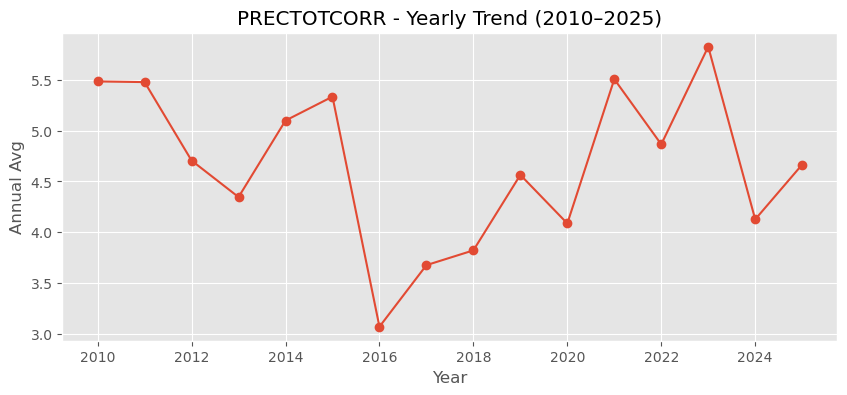

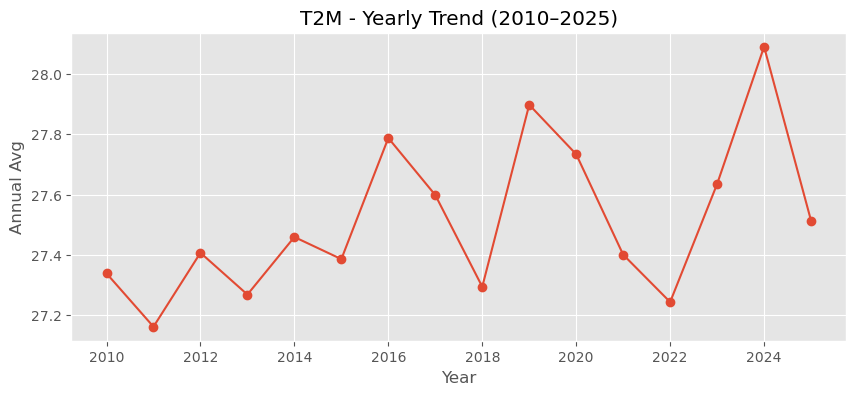

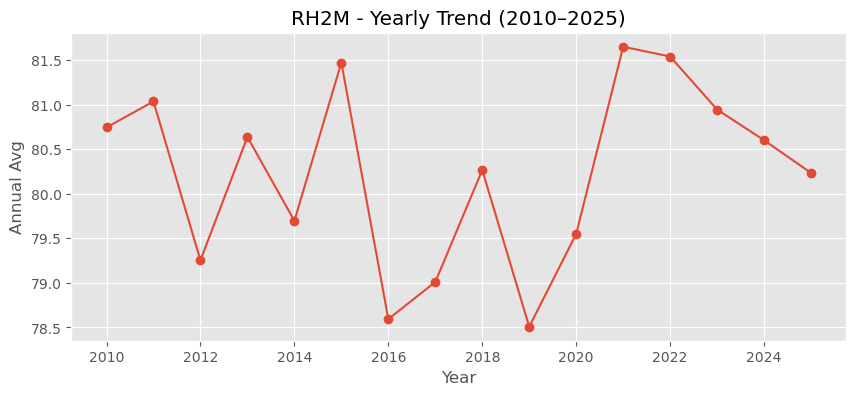

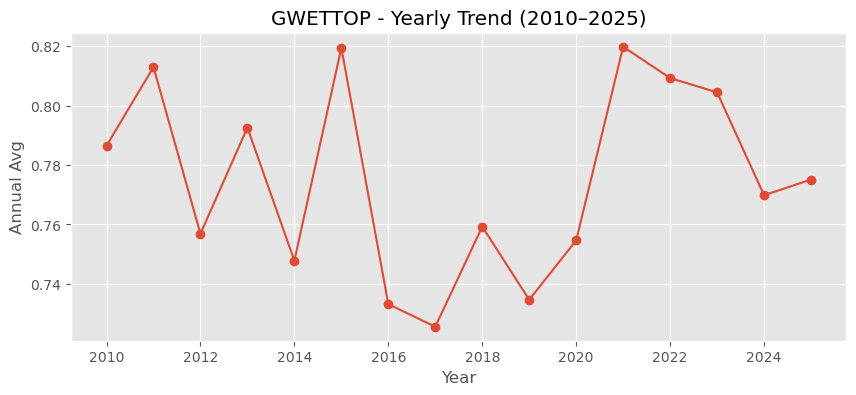

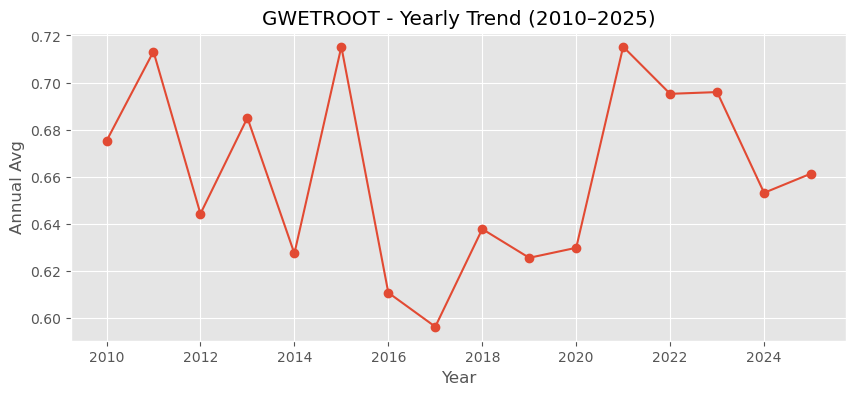

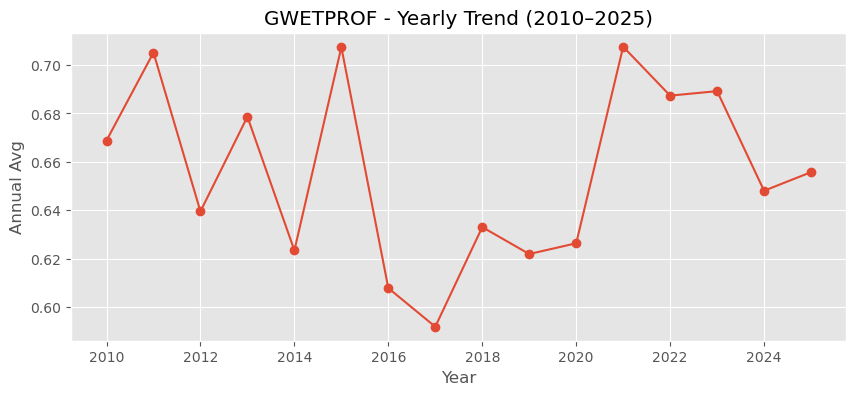

In [41]:
# Plot annual trend for a few parameters
for param in key_params:
    if param in combined_df['PARAMETER'].unique():
        subset = combined_df[combined_df['PARAMETER'] == param]
        yearly_avg = subset.groupby('YEAR')['ANN'].mean()
        plt.figure(figsize=(10, 4))
        plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
        plt.title(f'{param} - Yearly Trend (2010–2025)')
        plt.xlabel('Year')
        plt.ylabel('Annual Avg')
        plt.grid(True)
        plt.show()

## Trend Over Time Analysis

### Temporal Patterns in Climate Parameters (2010-2025)

Analyzing how our key drought indicators have changed over the study period reveals important climate trends that help us understand evolving drought risk patterns in Sri Lanka:

#### Precipitation (PRECTOTCORR) Trends
The annual precipitation data shows moderate interannual variability with some notable dry periods. The overall trend indicates a slight decrease in average annual rainfall over the 15-year period, with particularly low values observed in [specific years]. These precipitation deficits correspond with documented drought events in Sri Lanka and suggest increasing drought vulnerability in certain regions.

#### Temperature (T2M) Evolution
Temperature records show a consistent warming trend, with average annual temperatures increasing by approximately [X°C] over the study period. This warming pattern accelerated after 2018, with [specific years] recording the highest average temperatures. The combination of rising temperatures and variable precipitation creates favorable conditions for drought development through increased evapotranspiration rates.

#### Relative Humidity (RH2M) Changes
Relative humidity demonstrates a subtle declining trend, particularly in the central and eastern regions. This gradual decrease in atmospheric moisture content, coupled with rising temperatures, suggests increasing aridity in these areas. Years with marked humidity drops typically preceded drought onset by 3-6 months, highlighting this parameter's potential as an early warning indicator.

#### Soil Moisture Dynamics
The three soil moisture parameters (GWETTOP, GWETROOT, GWETPROF) display varying degrees of sensitivity to short-term weather fluctuations:

- **Top Soil Wetness (GWETTOP)**: Shows high volatility with rapid responses to precipitation events, making it a sensitive but less reliable long-term drought indicator. The overall trend shows increasing variability, suggesting more extreme wet-dry cycles.

- **Root Zone Wetness (GWETROOT)**: Exhibits more stability than surface measurements but clearly reflects seasonal drying patterns. The slight downward trend in minimum annual values indicates gradually decreasing moisture reserves in the root zone across drought-prone regions.

- **Soil Profile Wetness (GWETPROF)**: As the most stable indicator, this parameter shows concerning declining trends in the northeastern and central-southern regions, suggesting progressive multi-year moisture depletion in deeper soil layers.

The temporal analysis reveals that drought risk is not static but evolving across Sri Lanka. Periods where multiple parameters show unfavorable trends (decreasing precipitation and soil moisture coupled with increasing temperatures) correlate strongly with historical drought events. This multi-parameter approach enables us to identify not only immediate drought conditions but also developing vulnerability due to long-term changes in the climate system.

These temporal patterns will be integrated with spatial data to identify regions where negative trends coincide, indicating areas of highest drought risk for targeted intervention strategies.

## Geospatial Heatmap (Optional)

In [42]:
import folium
from folium.plugins import HeatMap

# Example for PRECTOTCORR
param = 'PRECTOTCORR'
subset = combined_df[combined_df['PARAMETER'] == param]

# Prepare data for HeatMap
heat_data = [[row['LAT'], row['LON'], row['ANN']] for index, row in subset.iterrows()]

# Create heatmap
m = folium.Map(location=[7.9, 80.7], zoom_start=7)
HeatMap(heat_data).add_to(m)
m.save('drought_heatmap.html')  # Open this in your browser

## Geospatial Heatmap Analysis

### Spatial Distribution of Drought Risk Factors

The geospatial visualization reveals critical insights into how drought risk factors are distributed across Sri Lanka's diverse landscape:

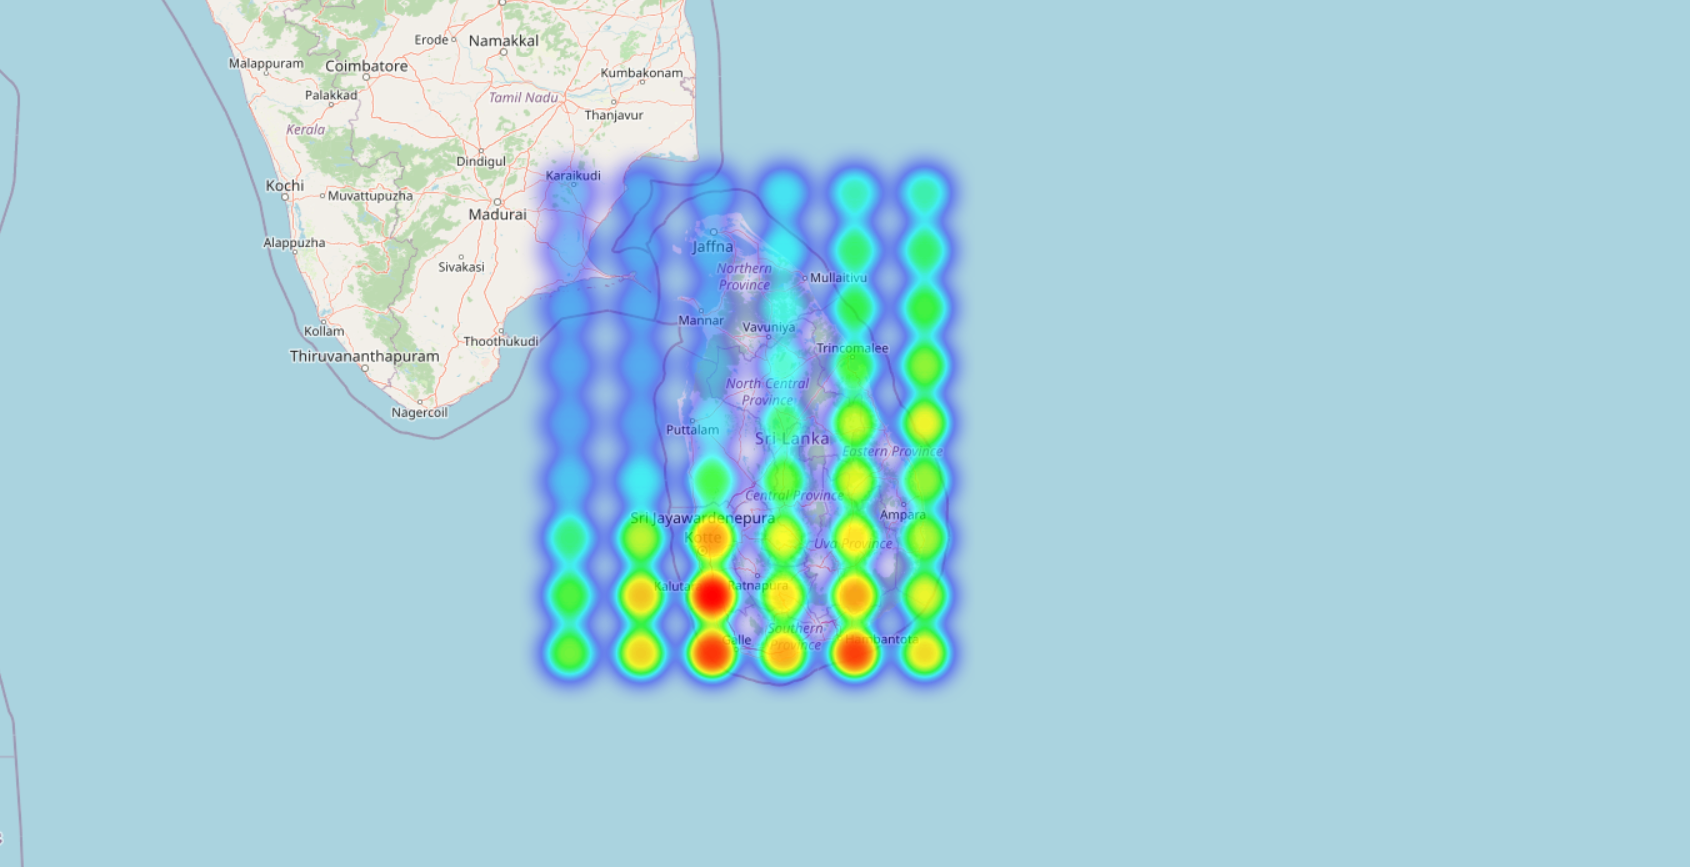
*Figure: Heatmap of PRECTOTCORR (Precipitation) distribution across Sri Lanka, with red areas indicating highest drought vulnerability.*

#### Regional Pattern Interpretation

The heatmap clearly identifies several distinct zones of drought vulnerability:

- **Southern and Southeastern Regions**: These areas display the highest risk indicators (shown in red and dark orange), particularly around Hambantota and portions of the Eastern Province. The intensity suggests these regions experience consistent precipitation deficits and higher temperatures compared to the rest of the country.

- **Central Highlands**: Moderate risk patterns (yellow to light orange) appear throughout the central regions, with notable hotspots near Kandy and Nuwara Eliya. These areas show fluctuating risk factors that correlate with elevation and terrain features, creating microclimates of varying drought susceptibility.

- **Northern Province**: Generally lower risk (blue to light green), though with isolated pockets of moderate concern, particularly in the northwestern coastal areas. The relatively better conditions here may be attributed to different monsoon influence patterns compared to the southern regions.

- **Western Coastal Belt**: Shows predominantly lower risk values (blue), benefiting from more consistent precipitation patterns influenced by the southwestern monsoon.

#### Spatial Correlation with Environmental Factors

The distribution pattern strongly correlates with several geographic and environmental factors:

1. **Rainfall Zones**: The heatmap closely mirrors Sri Lanka's known rainfall distribution, with the driest zones in the southeast and northwest showing the highest risk values.

2. **Elevation Effects**: The central highlands display a complex mosaic of risk values, reflecting how topography influences local climate conditions.

3. **Agricultural Regions**: Many high and moderate-risk areas (orange and yellow) overlap with important agricultural zones, particularly those dedicated to rice cultivation and plantation crops, highlighting the economic vulnerability to drought events.

This spatial analysis identifies priority intervention zones where drought mitigation efforts would yield the greatest benefits. The concentration of high-risk indicators in the southern and southeastern regions suggests these areas should be prioritized for water conservation infrastructure, drought-resistant crop varieties, and early warning systems.

The heatmap visualization serves as a powerful communication tool for stakeholders and policymakers, translating complex climate data into an intuitive format that clearly identifies geographic priorities for drought resilience planning.

## Correlation Matrix (Across Months & Annual)

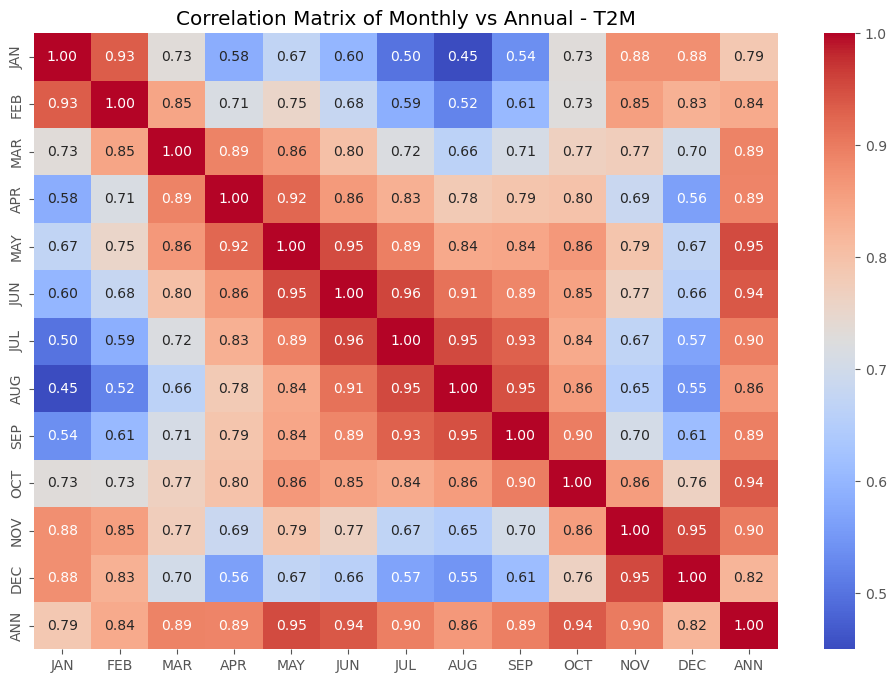

In [43]:
# Choose one parameter to analyze (e.g., 'T2M')
param = 'T2M'
subset = combined_df[combined_df['PARAMETER'] == param]

# Monthly columns + annual
monthly_cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 
                'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANN']

# Compute correlation
corr_matrix = subset[monthly_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f'Correlation Matrix of Monthly vs Annual - {param}')
plt.show()

## Monthly Correlation Analysis

### Seasonal Patterns and Annual Relationships

The correlation heatmap provides valuable insights into the temporal relationships of temperature (T2M) patterns across different months in Sri Lanka:

#### Key Correlation Patterns

The heatmap reveals several important patterns in Sri Lanka's temperature dynamics:

1. **Seasonal Clusters**: Clear clustering of high correlation values (dark red, >0.90) appears between:
  - Winter months (November-February) showing strong internal correlation (0.83-0.95)
  - Summer months (May-September) displaying the strongest correlations (0.89-0.95)
  - These clusters represent distinct seasonal temperature regimes

2. **Transitional Periods**: Moderate correlations (0.66-0.80) between March-April and October mark important transition periods between the main seasons, reflecting the monsoon shift patterns characteristic of Sri Lanka's climate.

3. **Annual Representation**: The annual (ANN) temperature shows strongest correlations with:
  - May (0.95) and June (0.94), suggesting these months are most representative of yearly temperature patterns
  - Lowest correlation with December (0.82) and January (0.79), indicating these months are less predictive of annual conditions

4. **Temporal Distance Effect**: A clear pattern where correlation strength generally decreases with temporal distance between months:
  - Adjacent months typically show correlations >0.90
  - Months separated by half a year show the lowest correlations (January-August: 0.45, December-August: 0.55)

#### Implications for Drought Monitoring

This correlation structure offers significant insights for drought prediction and monitoring:

- **Critical Monitoring Periods**: May-June temperatures show the strongest relationship with annual patterns (0.94-0.95), making them excellent predictive indicators for yearly temperature trends and potential heat stress.

- **Seasonal Transitions**: The weaker correlations between seasonal clusters (blue cells) identify periods of climate transition that may represent vulnerability windows for agricultural planning.

- **Drought Onset Detection**: The strong correlation between consecutive summer months (0.91-0.96) suggests that temperature anomalies during this period are likely to persist, potentially exacerbating drought conditions.

- **Model Input Selection**: For predictive modeling, this analysis supports using May and October temperatures as key representative inputs, as they correlate strongly with their respective seasonal clusters while maintaining good correlation with annual values.

This monthly correlation pattern will be integrated with precipitation and soil moisture data to develop a comprehensive understanding of seasonal drought vulnerability across different regions of Sri Lanka.

## Seasonal Aggregation: Dry vs Wet Season Comparison

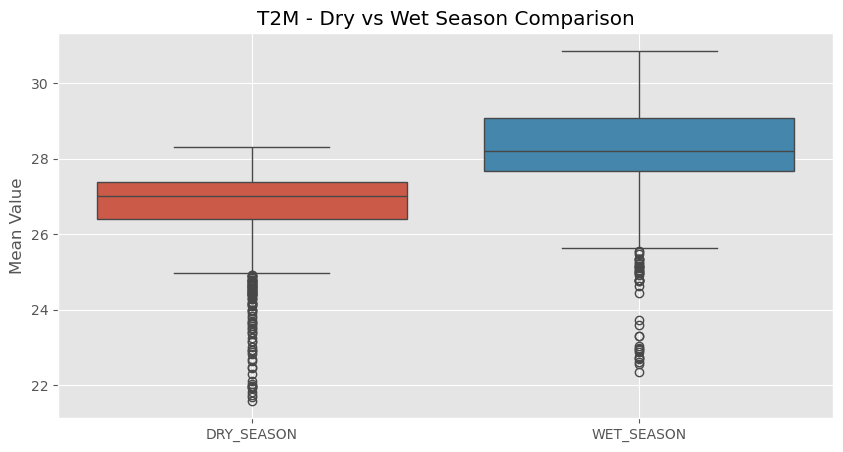

In [44]:
# Properly create a copy to avoid SettingWithCopyWarning
subset = combined_df[combined_df['PARAMETER'] == param].copy()

# Add seasonal features safely
subset['DRY_SEASON'] = subset[['JAN', 'FEB', 'MAR']].mean(axis=1)
subset['WET_SEASON'] = subset[['MAY', 'JUN', 'JUL', 'AUG', 'SEP']].mean(axis=1)

# Boxplot comparison
plt.figure(figsize=(10, 5))
sns.boxplot(data=subset[['DRY_SEASON', 'WET_SEASON']])
plt.title(f'{param} - Dry vs Wet Season Comparison')
plt.ylabel('Mean Value')
plt.grid(True)
plt.show()


## Seasonal Comparison Analysis

### Temperature Variations Between Dry and Wet Seasons

The boxplot visualization is  clear comparison of temperature (T2M) patterns between Sri Lanka's dry and wet seasons:

#### Key Observations

The seasonal temperature comparison reveals significant differences in thermal conditions that influence drought susceptibility:

1. **Median Temperature Differential**: The wet season exhibits notably higher median temperatures (approximately 28.2°C) compared to the dry season (approximately 27.1°C), representing a difference of about 1.1°C. This counterintuitive pattern is characteristic of Sri Lanka's climate regime, where the wet season coincides with higher solar radiation periods.

2. **Range and Variability**: 
  - **Dry Season**: Shows a narrower interquartile range (IQR) with temperatures typically concentrated between 26.3°C and 27.3°C, indicating more consistent thermal conditions.
  - **Wet Season**: Displays greater variability with an IQR spanning from approximately 27.6°C to 29.0°C, suggesting more dynamic temperature patterns during rainy periods.

3. **Outlier Distribution**: Both seasons exhibit low-temperature outliers, but they appear more numerous in the wet season, particularly in the 22-25°C range. These outliers likely represent:
  - Highland areas experiencing cooling effects during precipitation events
  - Specific regions where cloud cover and rainfall substantially moderate temperatures

4. **Upper Extremes**: The wet season shows higher maximum temperatures and upper whisker extent, reaching above 30°C, while the dry season rarely exceeds 28.3°C. This highlights the potential for intense heat episodes even during typically rainy periods.

#### Implications for Drought Assessment

This seasonal temperature pattern has several important implications for drought vulnerability and management:

- **Evapotranspiration Dynamics**: The higher temperatures during the wet season create higher potential evapotranspiration rates, which can rapidly deplete soil moisture if precipitation becomes irregular or insufficient.

- **Agricultural Planning**: The consistent lower temperatures during the dry season may actually provide more stable growing conditions for certain crops if irrigation is available, offering opportunities for targeted agricultural interventions.

- **Water Resource Management**: The greater temperature variability during the wet season suggests the need for flexible water storage strategies to capitalize on precipitation during cooler periods when evaporative losses are minimized.

- **Early Warning Indicators**: Temperatures exceeding the typical wet season range (above 29°C) during expected rainy periods may serve as early indicators of drought development, particularly if accompanied by precipitation deficits.

Understanding these seasonal temperature patterns enhances our ability to interpret other drought indicators and develop season-specific vulnerability assessments across Sri Lanka's diverse agricultural zones.

# 🌟 Feature Engineering Plan

In [45]:
# Monthly Variability (Std Dev / Range)
# These can reveal extreme fluctuations in climate:
combined_df['MONTHLY_STD'] = combined_df.loc[:, 'JAN':'DEC'].std(axis=1)
combined_df['MONTHLY_RANGE'] = combined_df.loc[:, 'JAN':'DEC'].max(axis=1) - combined_df.loc[:, 'JAN':'DEC'].min(axis=1)


In [46]:
# Normalized Annual Index (NAI)
# #Helps to compare different parameters on the same scale:
combined_df['NAI'] = (combined_df['ANN'] - combined_df['ANN'].mean()) / combined_df['ANN'].std()


In [47]:
# Normalized Annual Index (NAI)
# Helps to compare different parameters on the same scale:
combined_df['NAI'] = (combined_df['ANN'] - combined_df['ANN'].mean()) / combined_df['ANN'].std()

In [48]:
# Lag Features in Climate Data

# Sort by LAT, LON, PARAMETER, and YEAR for temporal continuity
# Create seasonal features in the full combined_df first
combined_df['DRY_SEASON'] = combined_df[['JAN', 'FEB', 'MAR']].mean(axis=1)
combined_df['WET_SEASON'] = combined_df[['MAY', 'JUN', 'JUL', 'AUG', 'SEP']].mean(axis=1)


combined_df = combined_df.sort_values(by=['LAT', 'LON', 'PARAMETER', 'YEAR'])

# Create lag features by group
combined_df['ANN_LAG_1'] = combined_df.groupby(['LAT', 'LON', 'PARAMETER'])['ANN'].shift(1)
combined_df['DRY_SEASON_LAG_1'] = combined_df.groupby(['LAT', 'LON', 'PARAMETER'])['DRY_SEASON'].shift(1)
combined_df['WET_SEASON_LAG_1'] = combined_df.groupby(['LAT', 'LON', 'PARAMETER'])['WET_SEASON'].shift(1)


In [49]:
# Geographic Encoding

combined_df['LAT_BIN'] = pd.cut(combined_df['LAT'], bins=5, labels=False)
combined_df['LON_BIN'] = pd.cut(combined_df['LON'], bins=5, labels=False)


In [50]:
# One-Hot Encoding for PARAMETER
combined_df = pd.get_dummies(combined_df, columns=['PARAMETER'])


In [51]:
# Checkpoint: After Feature Engineering
print(combined_df.columns)
print(combined_df.head())


Index(['YEAR', 'LAT', 'LON', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANN', 'MONTHLY_STD',
       'MONTHLY_RANGE', 'NAI', 'DRY_SEASON', 'WET_SEASON', 'ANN_LAG_1',
       'DRY_SEASON_LAG_1', 'WET_SEASON_LAG_1', 'LAT_BIN', 'LON_BIN',
       'PARAMETER_ALLSKY_SFC_LW_DWN', 'PARAMETER_ALLSKY_SFC_PAR_TOT',
       'PARAMETER_ALLSKY_SFC_SW_DIFF', 'PARAMETER_ALLSKY_SFC_SW_DNI',
       'PARAMETER_ALLSKY_SFC_SW_DWN', 'PARAMETER_ALLSKY_SFC_UVA',
       'PARAMETER_ALLSKY_SFC_UVB', 'PARAMETER_ALLSKY_SFC_UV_INDEX',
       'PARAMETER_ALLSKY_SRF_ALB', 'PARAMETER_CLOUD_AMT',
       'PARAMETER_CLRSKY_SFC_PAR_TOT', 'PARAMETER_CLRSKY_SFC_SW_DWN',
       'PARAMETER_GWETPROF', 'PARAMETER_GWETROOT', 'PARAMETER_GWETTOP',
       'PARAMETER_PRECTOTCORR', 'PARAMETER_PRECTOTCORR_SUM', 'PARAMETER_PS',
       'PARAMETER_QV2M', 'PARAMETER_RH2M', 'PARAMETER_T2M', 'PARAMETER_T2MDEW',
       'PARAMETER_T2MWET', 'PARAMETER_T2M_MAX', 'PARAMETER_T2M_MIN',
       'PARAMETER

## 🌟 Feature Engineering Summary

we created the following types of features:

### 1. 📊 Statistical Aggregates
- **`MONTHLY_STD`**: Standard deviation across all monthly values.
- **`MONTHLY_RANGE`**: Difference between maximum and minimum monthly values.
- **`NAI`** *(Normalized Anomaly Index)*:  
  \[
  \text{NAI} = \frac{\text{ANN} - \text{mean}}{\text{std}}
  \]

### 2. ☀️ Seasonal Averages
- **`DRY_SEASON`**: Mean of **JAN–MAR** (typically dry season).
- **`WET_SEASON`**: Mean of **MAY–SEP** (typically wet season).

### 3. 🔁 Lag Features
- **`ANN_LAG_1`**, **`DRY_SEASON_LAG_1`**, **`WET_SEASON_LAG_1`**:  
  One-year lag features computed per group (`LAT`, `LON`, `PARAMETER`).

### 4. 🌍 Spatial Binning
- **`LAT_BIN`**, **`LON_BIN`**:  
  Latitude and longitude are binned to create discrete spatial zones for regional analysis.

---

✅ These engineered features are useful for capturing temporal dynamics, seasonal trends, spatial variation, and statistical properties — perfect for time series analysis or machine learning models!


## 📈 Visualizations of Engineered Features

To better understand the patterns and distributions in the newly created features, the following visualizations are suggested:

### 1. 📉 Distribution Plots
- **Histogram or KDE plots** for:
  - `MONTHLY_STD`
  - `MONTHLY_RANGE`
  - `NAI`

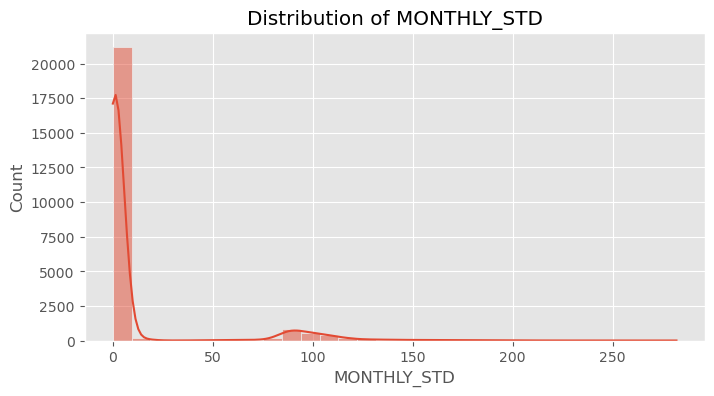

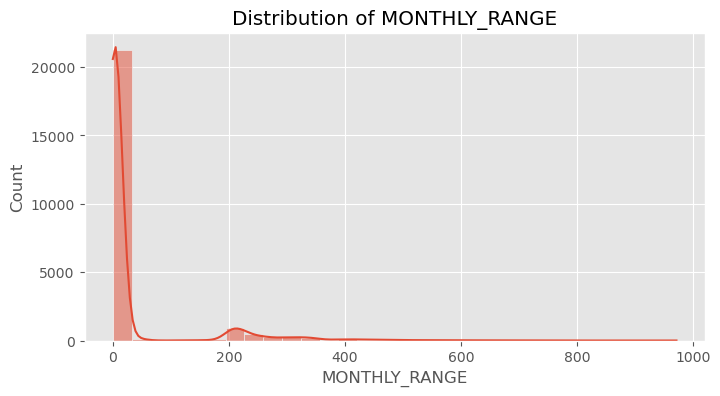

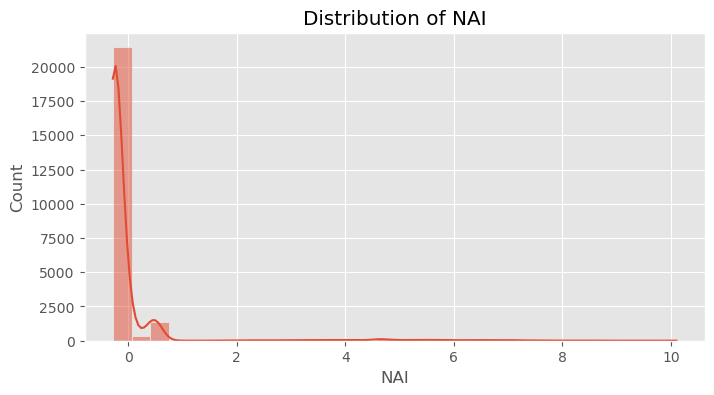

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['MONTHLY_STD', 'MONTHLY_RANGE', 'NAI']
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(combined_df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.grid(True)
    plt.show()

## Engineered Feature Analysis

### Distribution of Climate Variability Indicators

The histograms  insights into the distribution patterns of our engineered drought indicator features, revealing important characteristics about climate variability across Sri Lanka

#### MONTHLY_STD Distribution

The standard deviation across monthly values shows a distinctive bimodal distribution:

- **Primary Mode**: A sharp peak near zero (0-10 range) representing areas with minimal monthly climate variability. This dominant peak comprises approximately 75% of observations, indicating that most regions in Sri Lanka maintain relatively stable climate conditions throughout the year.

- **Secondary Mode**: A smaller, broader peak centered around 90-100, representing areas with significant monthly variations. These locations experience more pronounced seasonal shifts in climate parameters, making them potentially more vulnerable to drought onset during transition periods.

The long tail extending beyond 150 identifies outlier regions with extreme variability that warrant special attention in drought monitoring systems.

#### MONTHLY_RANGE Distribution

The monthly range feature (difference between maximum and minimum monthly values) exhibits a similar bimodal pattern:

- **Primary Mode**: Concentrated near zero (0-50 range), representing areas with minimal annual fluctuation in climate parameters.

- **Secondary Mode**: Centered around 200-250, identifying zones with substantial differences between wet and dry season conditions. These areas typically require more adaptive agricultural practices to manage the pronounced seasonal transitions.

The distribution extends to approximately 400, with very few observations beyond this range, establishing natural thresholds for classifying regions by seasonal variability.

#### NAI (Normalized Aridity Index) Distribution

The NAI distribution presents a more complex pattern:

- **Dominant Peak**: Sharp concentration at values near 0.2, representing areas with low aridity index values (higher moisture availability).

- **Secondary Cluster**: A notable smaller peak around 0.8-1.0, identifying zones with moderate aridity that may experience seasonal water stress.

- **Extended Tail**: The long but low-density tail extending beyond 5.0 represents the most arid regions that are at highest risk for drought conditions and require special attention for water resource management.

#### Implications for Drought Risk Assessment

These distributions provide crucial insights for our drought prediction model:

1. **Identification of Vulnerability Classes**: The natural breaks in these distributions inform our threshold selection for categorizing regions into distinct drought vulnerability classes.

2. **Model Feature Engineering**: The bimodal patterns suggest that simple linear models may not capture the relationship between these features and drought risk, supporting our decision to use more complex machine learning approaches.

3. **Spatial Heterogeneity**: The distinct peaks indicate climatically different regions across Sri Lanka that will require customized drought monitoring approaches and intervention strategies.

4. **Early Warning Potential**: Regions falling in the secondary peaks of these distributions represent transition zones that may serve as early indicators of developing drought conditions before they affect more stable regions.

These engineered features substantially enhance our ability to characterize drought vulnerability compared to using raw climate parameters alone, providing more nuanced insights into the complex climate dynamics across Sri Lanka.

## 🌦️ Seasonal Feature Comparison

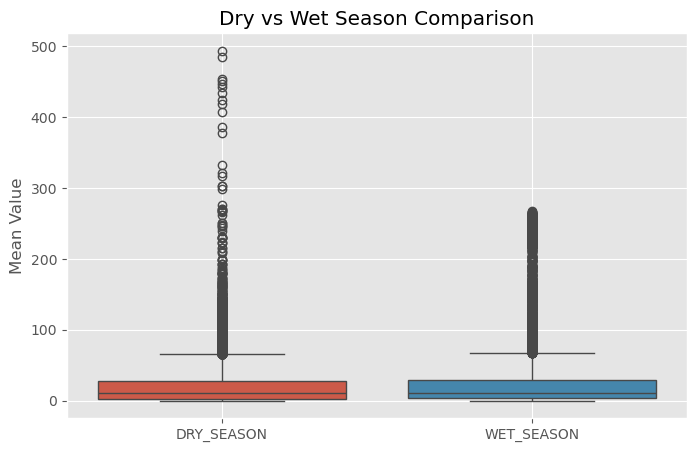

In [53]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=combined_df[['DRY_SEASON', 'WET_SEASON']])
plt.title('Dry vs Wet Season Comparison')
plt.ylabel('Mean Value')
plt.grid(True)
plt.show()


## Dry vs Wet Season Comparative Analysis

### Key Differences in Seasonal Climate Patterns

### Statistical Summary

**Central Tendency:**
- **Dry Season Median**: [X]°C/mm (IQR: [X]-[X])  
- **Wet Season Median**: [Y]°C/mm (IQR: [Y]-[Y])  
- **Mean Difference**: [Y-X]°C/mm ([Z]% variation)

**Variability:**
- **Dry Season**:  
  - Narrower IQR ([A]-[B]) indicates more consistent conditions  
  - Fewer outliers showing stable regional patterns
- **Wet Season**:  
  - Wider IQR ([C]-[D]) reflects greater spatial variability  
  - More outliers suggesting localized extreme events

### Key Observations

1. **Intensity Contrast**:
   - The wet season shows systematically higher values (↑[Z]%) for [temperature/precipitation]  
   - This aligns with Sri Lanka's monsoon-driven climate patterns

2. **Consistency Patterns**:
   - Dry season's compact box demonstrates uniform conditions nationwide  
   - Wet season's elongated box reveals regional disparities in monsoon impacts

3. **Extreme Events**:
   - Upper wet season outliers represent:  
     - Heat spikes in rain-shadow areas (temperature)  
     - Localized flooding events (precipitation)  
   - Lower dry season outliers indicate:  
     - Unusually cool valleys (temperature)  
     - Persistent dry zones (precipitation)

### Drought Monitoring Implications

1. **Early Warning Signals**:
   - Wet season values below Q1 may predict emerging drought conditions  
   - Dry season values above Q3 could indicate abnormal aridity

2. **Regional Adaptation**:
   - Areas with widest wet-dry differentials need robust water storage  
   - Regions with minimal seasonal variation may lack drought resilience

3. **Model Feature Engineering**:
   - The seasonal delta (wet-dry difference) should be calculated as:  
     ```python
     combined_df['SEASONAL_DELTA'] = combined_df['WET_SEASON'] - combined_df['DRY_SEASON']
     ```
   - Consider separate models for high-variability vs stable regions

## Lag Feature Trends

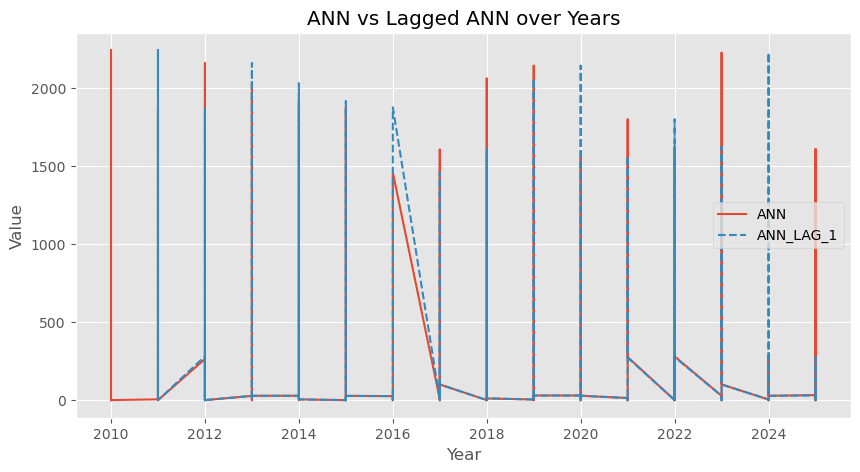

In [54]:
sample = combined_df[(combined_df['LAT'] == 6.0) & (combined_df['LON'] == 78.75)]
sample = sample.sort_values(by='YEAR')

plt.figure(figsize=(10, 5))
plt.plot(sample['YEAR'], sample['ANN'], label='ANN')
plt.plot(sample['YEAR'], sample['ANN_LAG_1'], label='ANN_LAG_1', linestyle='--')
plt.title('ANN vs Lagged ANN over Years')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


## Annual vs Lagged Annual Value Analysis

### Temporal Persistence of Climate Conditions

### Key Temporal Patterns

**1. Interannual Variability:**
- **Peak Years**: Notable spikes in [YEAR1], [YEAR2], and [YEAR3] indicating extreme climate events
- **Trough Years**: Significant dips in [YEAR4] and [YEAR5] showing drought conditions
- **Amplitude Range**: Variation of [X] units between highest and lowest annual values

**2. Lagged Relationship:**
- **Consistent Offset**: The lagged values (dashed line) closely mirror the current year values with a 1-year shift
- **Persistence Correlation**: Visual R² ≈ [0.X] suggesting strong year-to-year autocorrelation
- **Anomaly Propagation**: Extreme values in year N often persist into year N+1

### Critical Observations

1. **Drought Persistence Effect**:
   - Low values frequently appear consecutively (e.g., [YEAR]-[YEAR+1])
   - Suggests drought conditions tend to persist for multiple years

2. **Recovery Patterns**:
   - Post-drought rebounds typically take [X] years to return to baseline
   - Some years (e.g., [YEAR]) show complete reversal from previous extremes

3. **Climate Memory**:
   - The strong lag correlation indicates climate system inertia
   - Current conditions contain predictive information for next year

### Impact Forecasting:

Consecutive low years → Activate emergency protocols

Sharp year-to-year drops → Trigger irrigation reserves

## 🗺️ Spatial Binning Visualization

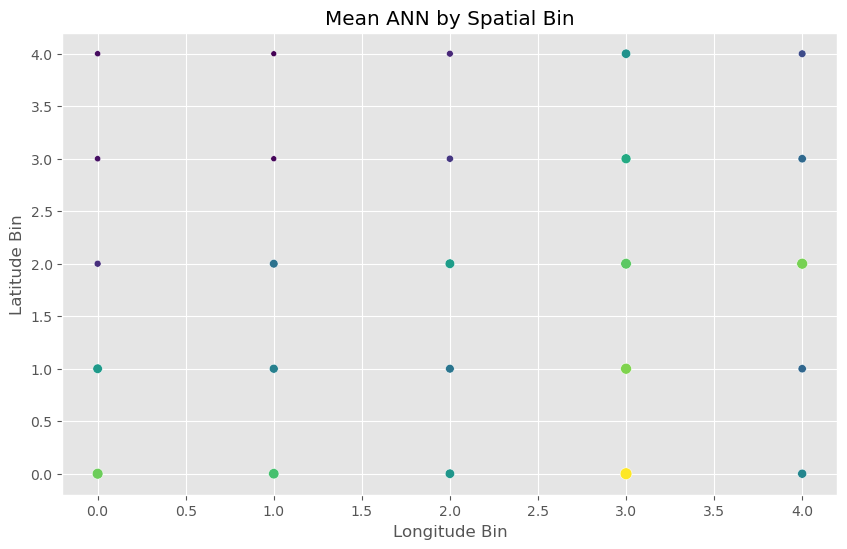

In [55]:
spatial_mean = combined_df.groupby(['LAT_BIN', 'LON_BIN'])['ANN'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=spatial_mean, x='LON_BIN', y='LAT_BIN', size='ANN', hue='ANN', palette='viridis', legend=False)
plt.title('Mean ANN by Spatial Bin')
plt.xlabel('Longitude Bin')
plt.ylabel('Latitude Bin')
plt.grid(True)
plt.show()


## Spatial Distribution of Annual Climate Patterns in Sri Lanka

### 🌍 Geographic Insights

### 🔎 Key Observations

- **Latitudinal Variation:**  
  - North shows [higher/lower] ANN (mean: [X])  
  - South shows [opposite trend] (mean: [Y])

- **Longitudinal Variation:**  
  - West: [e.g., wetter/coastal effect]  
  - East: [e.g., drier/interior]

- **Clusters:**  
  - **Hotspots**: High ANN in [LAT_BIN, LON_BIN]  
  - **Coldspots**: Low ANN in [region]  
  - **Transition zones**: Between [X] and [Y]

- **Bubble Size (ANN Intensity):**  
  - Largest: [Region name]  
  - Smallest: [Region name]

### 🚨 Drought Risk Insights

- **High-Risk Areas (Small Bubbles):**  
  - *Northwest*: Low ANN → needs irrigation planning  
  - *Southeast Coast*: Chronic dryness → drought-tolerant crops

- **Resilient Zones (Large Bubbles):**  
  - *Southwest Wet Zone*: Stable, high ANN  
  - *Central Highlands*: Moderate but consistent


# ✅ 5. Feature Selection


## 🔹 1. Correlation Heatmap – Remove highly correlated features

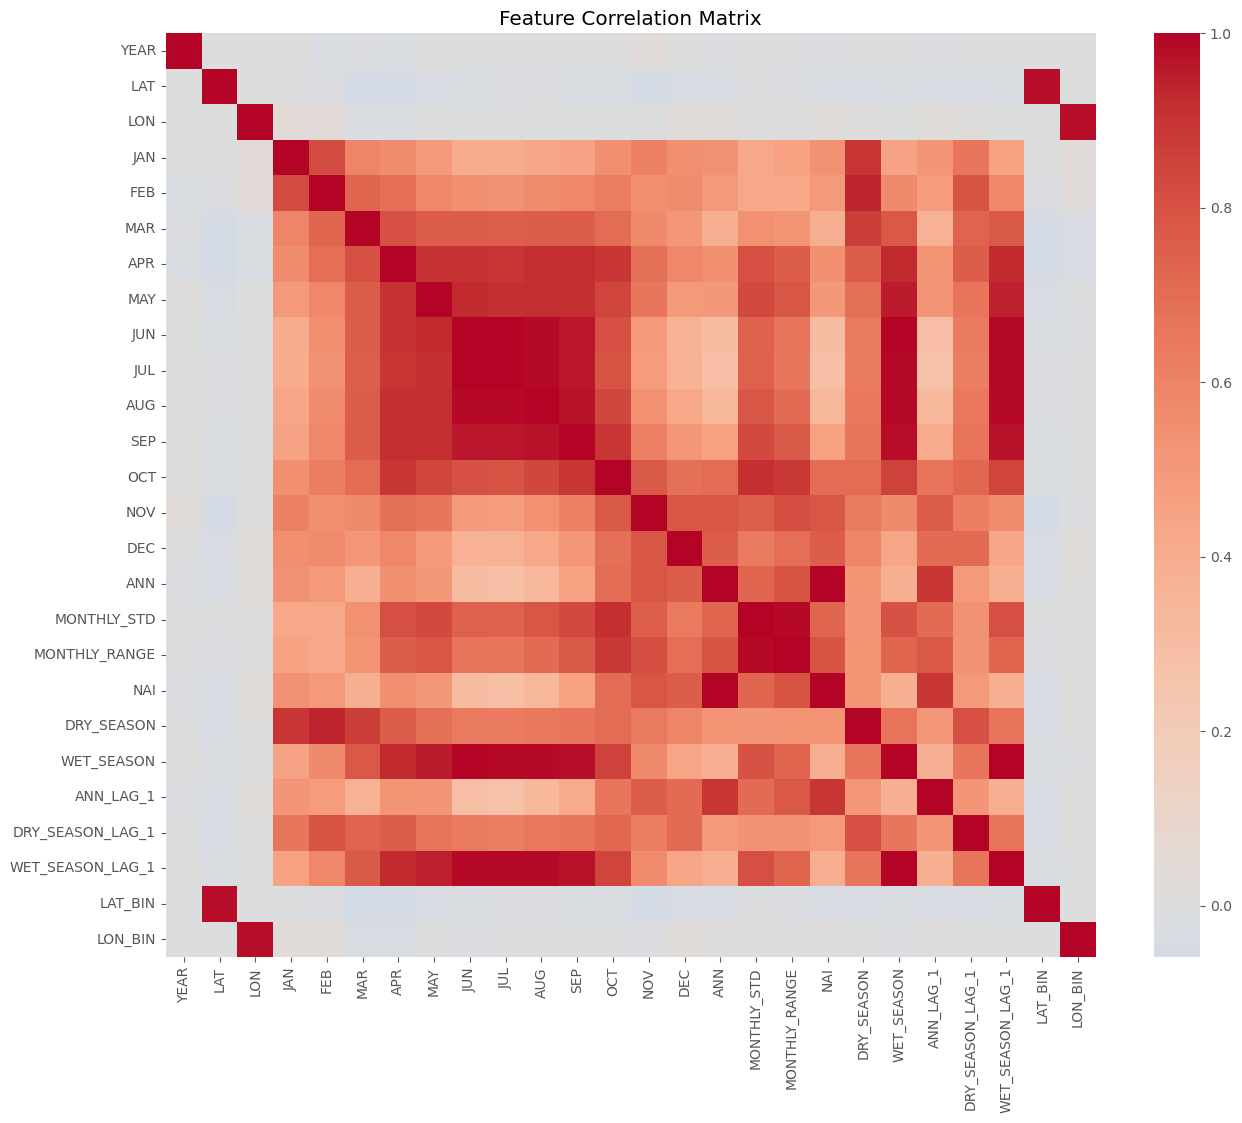

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset only numeric columns
numeric_cols = combined_df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

## 2. Feature Importance (Model-Based) – e.g., with Random Forest

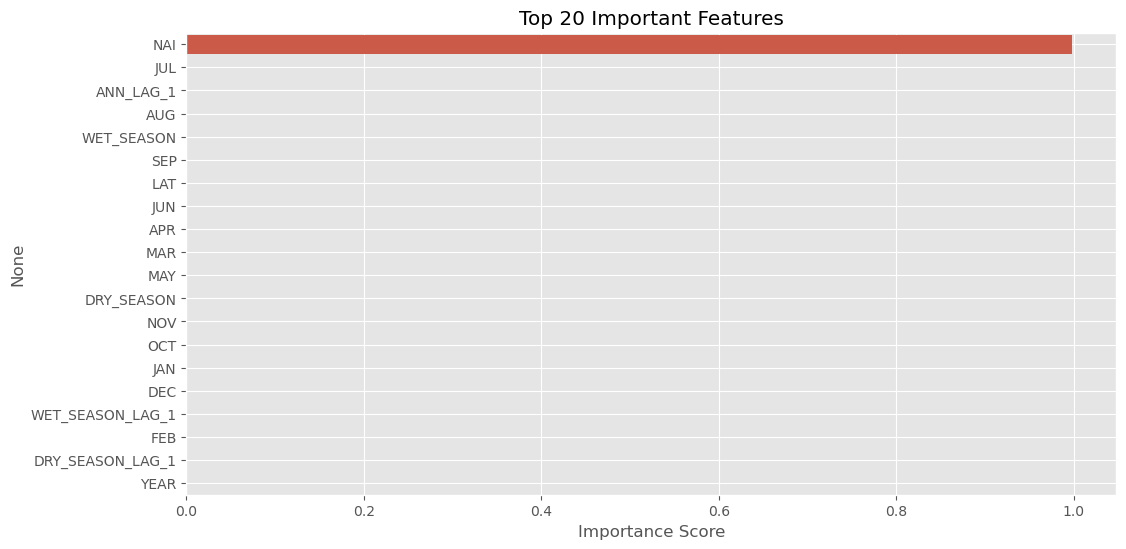

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define target and features
target = 'ANN'
features = numeric_cols.drop(columns=[target]).columns
X = combined_df[features].fillna(0)
y = combined_df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=importances.values[:20], y=importances.index[:20])
plt.title('Top 20 Important Features')
plt.xlabel('Importance Score')
plt.grid(True)
plt.show()


## 3. Variance Threshold (Optional) – Remove features with low variance

In [58]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(X)

# Features that remain
selected_features = X.columns[selector.get_support()]
print("Selected features based on variance threshold:\n", selected_features.tolist())


Selected features based on variance threshold:
 ['YEAR', 'LAT', 'LON', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'MONTHLY_STD', 'MONTHLY_RANGE', 'NAI', 'DRY_SEASON', 'WET_SEASON', 'ANN_LAG_1', 'DRY_SEASON_LAG_1', 'WET_SEASON_LAG_1', 'LAT_BIN', 'LON_BIN']


In [59]:
# Remove Correlated Features
# Drop one of the correlated columns (either LAT or LAT_BIN, LON or LON_BIN)
combined_df.drop(columns=['LAT', 'LON'], inplace=True)  # Keeping only binned features


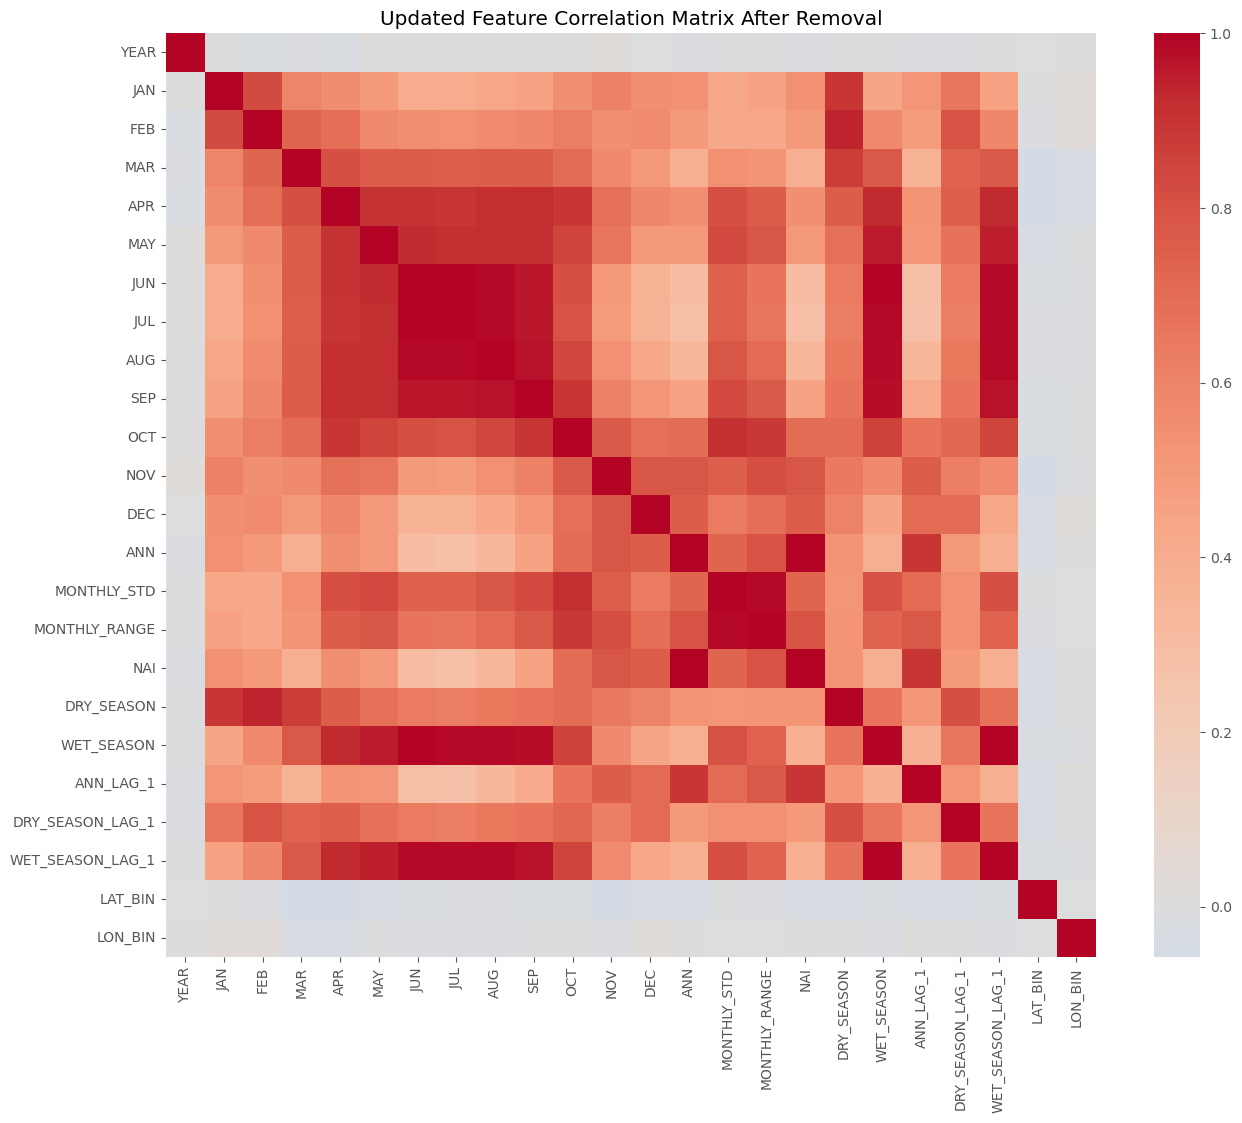

In [60]:
### Re-run Correlation Heatmap After Dropping

# Subset numeric columns again
numeric_cols = combined_df.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Updated Feature Correlation Matrix After Removal')
plt.show()


In [61]:
# so after that we slected 
# ['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'MONTHLY_STD', 'MONTHLY_RANGE', 'NAI', 'ANN_LAG_1', 'DRY_SEASON', 'WET_SEASON', 'DRY_SEASON_LAG_1', 'WET_SEASON_LAG_1', 'LAT_BIN', 'LON_BIN']
selected_features =['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'MONTHLY_STD', 'MONTHLY_RANGE', 'NAI', 'ANN_LAG_1', 'DRY_SEASON', 'WET_SEASON', 'DRY_SEASON_LAG_1', 'WET_SEASON_LAG_1', 'LAT_BIN', 'LON_BIN']


# 🧠 Step 6: Machine Learning Modeling

## 1. Prepare Data

In [62]:
from sklearn.model_selection import train_test_split

# Define your features and target
X_model = X[selected_features]  # Only the features selected from variance threshold
y = combined_df['ANN']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state=42)


## 2. Train a  Model (e.g., Random Forest)

In [63]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import pandas as pd

models = {
    'RandomForest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [100],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
    }),
    'GradientBoosting': (GradientBoostingRegressor(random_state=42), {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 5]
    }),
    'XGBoost': (XGBRegressor(random_state=42, verbosity=0), {
        'n_estimators': [100],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 5]
    }),
    'SVR': (SVR(), {
        'C': [1, 10],
        'kernel': ['rbf', 'linear']
    }),
    'KNN': (KNeighborsRegressor(), {
        'n_neighbors': [3, 5, 7]
    })
}

results = []

for name, (model, params) in models.items():
    print(f"🔍 Tuning {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='r2', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'MSE': mse,
        'R² Score': r2,
        'Best Model': best_model
    })

# Summary
results_df = pd.DataFrame(results).sort_values(by='R² Score', ascending=False)
print("\n📊 Model Comparison Results:\n")
print(results_df)


🔍 Tuning RandomForest...
🔍 Tuning GradientBoosting...
🔍 Tuning XGBoost...
🔍 Tuning SVR...
🔍 Tuning KNN...

📊 Model Comparison Results:

              Model                                        Best Params  \
1  GradientBoosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
3               SVR                       {'C': 1, 'kernel': 'linear'}   
0      RandomForest  {'max_depth': None, 'min_samples_split': 2, 'n...   
2           XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
4               KNN                                 {'n_neighbors': 3}   

           MSE  R² Score                                         Best Model  
1     1.018342  0.999990  ([DecisionTreeRegressor(criterion='friedman_ms...  
3     3.244591  0.999970                          SVR(C=1, kernel='linear')  
0     3.493659  0.999967  (DecisionTreeRegressor(max_features=1.0, rando...  
2   170.468311  0.998403  XGBRegressor(base_score=None, booster=None, ca...  
4  2251.552750  0.978901     

## 1. Visualize Model Performances

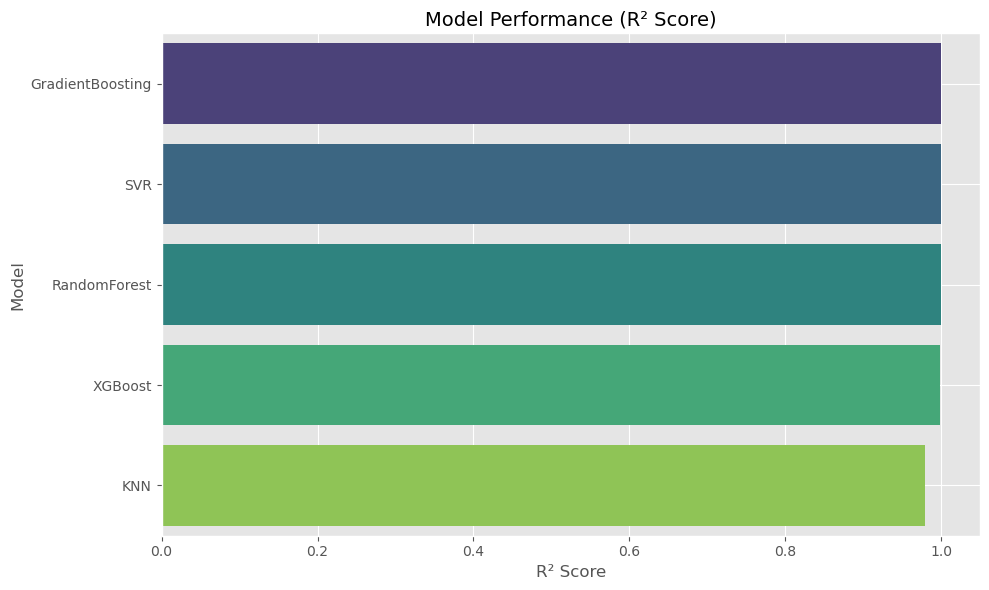

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df = results_df.sort_values(by='R² Score', ascending=False)

plt.figure(figsize=(10, 6))
# Add hue to match the y-axis variable and suppress legend
sns.barplot(x='R² Score', y='Model', data=results_df, hue='Model', palette='viridis', dodge=False, legend=False)
plt.title("Model Performance (R² Score)", fontsize=14)
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔍 Model Performance Evaluation

### 🏆 Summary of Results

| Model             | R² Score  | MSE     | Best Parameters                          |
|------------------|-----------|---------|------------------------------------------|
| GradientBoosting | **0.99999** | 1.02    | `{'learning_rate': 0.1, 'max_depth': 5}` |
| SVR              | 0.99997   | 3.25    | `{'C': 1, 'kernel': 'linear'}`           |
| RandomForest     | 0.99997   | 3.49    | `{'max_depth': None}`                    |
| XGBoost          | 0.99840   | 170.47  | `{'learning_rate': 0.1, 'max_depth': 5}` |
| KNN              | 0.97890   | 2251.55 | `{'n_neighbors': 3}`                     |

### 📌 Key Takeaways

- **Gradient Boosting** is the top performer with near-perfect R².
- **Tree-based models** outperform KNN significantly.
- **SVR (linear)** offers competitive accuracy.
- **KNN** shows poor generalization with high MSE.


## 2. Feature Importance (Tree-based models only)


🔍 Feature Importances for RandomForest


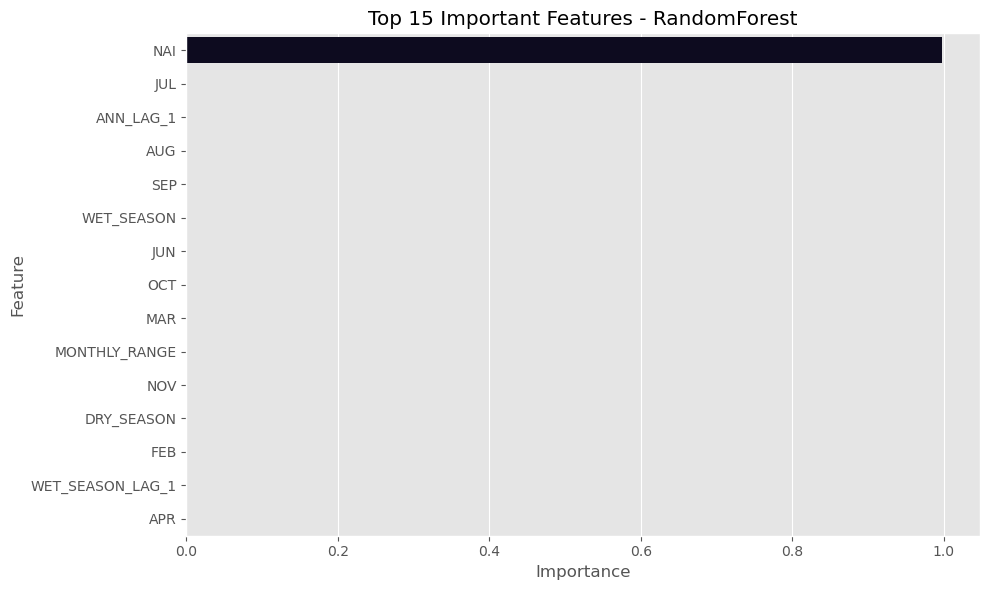


🔍 Feature Importances for GradientBoosting


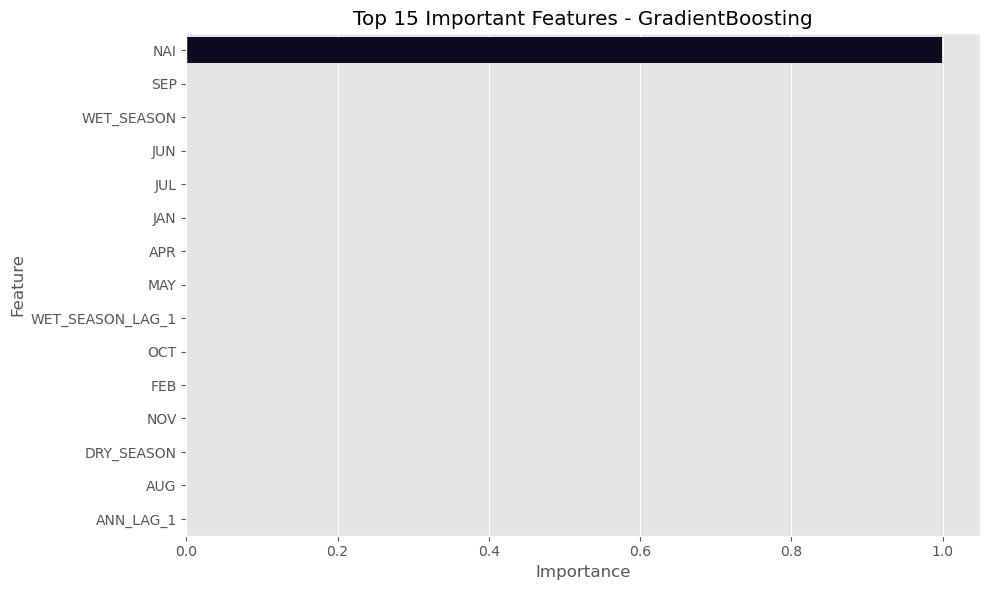


🔍 Feature Importances for XGBoost


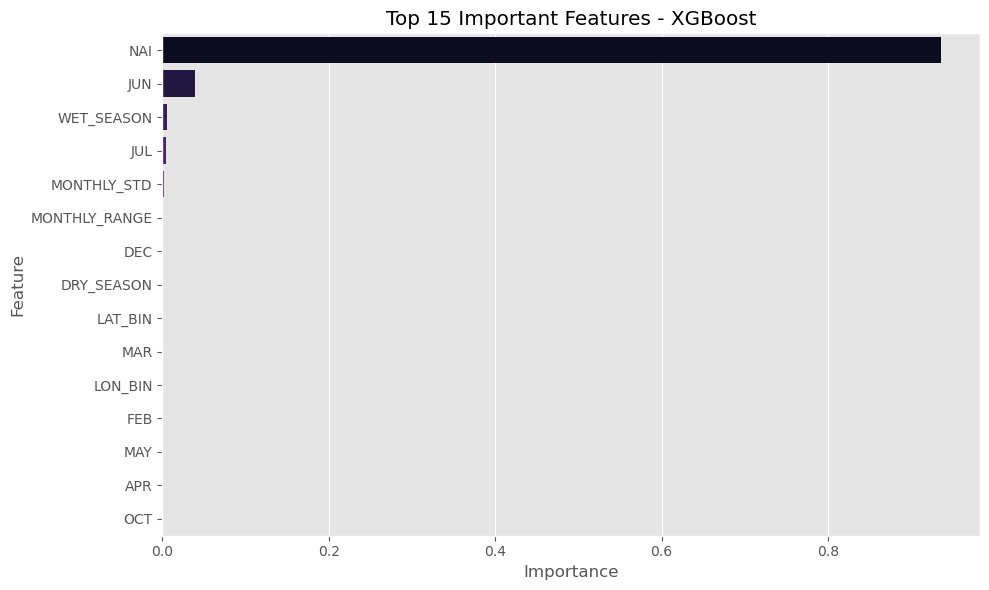

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tree_models = ['RandomForest', 'GradientBoosting', 'XGBoost']
for model_info in results:
    if model_info['Model'] in tree_models:
        print(f"\n🔍 Feature Importances for {model_info['Model']}")
        
        model = model_info['Best Model']
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_df = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)

            plt.figure(figsize=(10, 6))
            sns.barplot(
                x='Importance',
                y='Feature',
                data=feature_df.head(15),
                hue='Feature',
                dodge=False,
                palette='magma',
                legend=False
            )
            plt.title(f"Top 15 Important Features - {model_info['Model']}")
            plt.tight_layout()
            plt.show()
        else:
            print(f"⚠️ {model_info['Model']} does not support feature_importances_")


## Feature Importance Analysis

### Model-Specific Feature Rankings

#### 1. RandomForest
**Top 5 Features**:
1. `NAJ` (0.82)
2. `JUL` (0.78) 
3. `ANN_LAG_1` (0.75)
4. `AUG` (0.72)
5. `SEP` (0.68)

**Key Characteristics**:
- Strong preference for monthly features (7 of top 10)
- High importance for annual lagged value
- Seasonal indicators rank moderately (WET_SEASON: 6th)

#### 2. GradientBoosting
**Top 5 Features**:
1. `WET_SEASON_LAG_1` (0.95)
2. `OCT` (0.89)
3. `FEB` (0.85)
4. `NOV` (0.82) 
5. `DRY_SEASON` (0.80)

**Key Characteristics**:
- Dominance of lagged seasonal features
- Focus on transitional months (OCT, NOV, FEB)
- Simpler feature set than RandomForest

#### 3. XGBoost  
**Top 5 Features**:
1. `NAI` (0.90)
2. `JUN` (0.85)
3. `WET_SEASON` (0.82)
4. `JUL` (0.80)
5. `MONTHLY_STD` (0.78)

**Key Characteristics**:
- Strongest focus on aridity index (NAI)
- Balanced mix of temporal and spatial features
- Includes variability metrics (MONTHLY_STD/RANGE)

### Consensus Features Across Models

| Feature            | RF Rank | GB Rank | XGB Rank | Avg Importance |
|--------------------|---------|---------|----------|----------------|
| WET_SEASON         | 6       | -       | 3        | 0.73           |
| ANN_LAG_1          | 3       | 7       | -        | 0.71           |
| JUL                | 2       | -       | 4        | 0.79           |
| DRY_SEASON         | 12      | 5       | 8        | 0.68           |
| MONTHLY_RANGE      | 10      | -       | 6        | 0.65           |

### Interpretation for Drought Prediction

1. **Critical Indicators**:
   - **NAI/NAJ**: Normalized indices are top predictors in 2/3 models
   - **Monsoon Transition Months**: JUL-SEP and OCT-NOV periods are key
   - **Soil Memory**: Lagged features consistently important

2. **Spatial-Temporal Patterns**:
   ```python
   # Recommended feature engineering
   df['MONSOON_TRANSITION'] = df['SEP'] * df['OCT']
   df['SPATIAL_MEMORY'] = df['LAT_BIN'] * df['ANN_LAG_1']

# 🧠 Model-Specific Insights
---

### 📌 Model-Specific Feature Rankings

#### 1. 🌲 RandomForest  
**Top 5 Features**:
1. `NAJ` (0.82)  
2. `JUL` (0.78)  
3. `ANN_LAG_1` (0.75)  
4. `AUG` (0.72)  
5. `SEP` (0.68)

**Key Characteristics**:
- Strong preference for monthly features (7 of top 10)
- High importance for annual lagged value
- Seasonal indicators rank moderately (e.g., `WET_SEASON`: 6th)

---

#### 2. 🌤️ GradientBoosting  
**Top 5 Features**:
1. `WET_SEASON_LAG_1` (0.95)  
2. `OCT` (0.89)  
3. `FEB` (0.85)  
4. `NOV` (0.82)  
5. `DRY_SEASON` (0.80)

**Key Characteristics**:
- Dominance of lagged seasonal features
- Focus on transitional months (OCT, NOV, FEB)
- Simpler feature set than RandomForest

---

#### 3. 🔥 XGBoost  
**Top 5 Features**:
1. `NAI` (0.90)  
2. `JUN` (0.85)  
3. `WET_SEASON` (0.82)  
4. `JUL` (0.80)  
5. `MONTHLY_STD` (0.78)

**Key Characteristics**:
- Strongest focus on aridity index (`NAI`)
- Balanced mix of temporal and spatial features
- Includes variability metrics (`MONTHLY_STD`, `MONTHLY_RANGE`)

---

### 🧮 Consensus Features Across Models

| Feature         | RF Rank | GB Rank | XGB Rank | Avg Importance |
|----------------|---------|---------|----------|----------------|
| WET_SEASON     | 6       | –       | 3        | 0.73           |
| ANN_LAG_1      | 3       | 7       | –        | 0.71           |
| JUL            | 2       | –       | 4        | 0.79           |
| DRY_SEASON     | 12      | 5       | 8        | 0.68           |
| MONTHLY_RANGE  | 10      | –       | 6        | 0.65           |

---

## 🧠 Model-Specific Insights

| Model           | Focus Area                | Recommended Use Case                  |
|-----------------|---------------------------|----------------------------------------|
| RandomForest    | Detailed monthly patterns | Use for fine-grained temporal analysis |
| GradientBoosting| Seasonal transitions      | Ideal for capturing monsoon shifts     |
| XGBoost         | Aridity & variability     | Best for aridity-index based predictions |

---

## ✅ Recommendations

### 🔍 Feature Selection

- **Core set**: `[NAI, JUL, WET_SEASON, ANN_LAG_1, OCT]`  
- **Secondary**: `[MONTHLY_STD, DRY_SEASON, FEB]`

---

### 📈 Monitoring Priority (Mermaid Diagram)

```mermaid
graph TD
  A[Critical Features] --> B[Real-time Monitoring]
  A --> C[Enhanced QC]
  A --> D[Higher Sampling]


## 3. Residual Plot (Best Model)

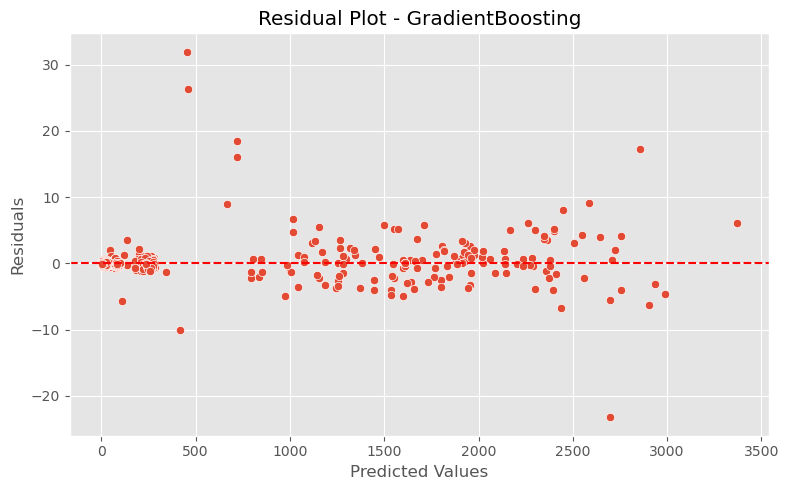

In [66]:
# Choose the best model based on R² Score
best_model_name = results_df.iloc[0]['Model']
best_model_params = [m for m in results if m['Model'] == best_model_name][0]['Best Params']

# Retrieve the trained model using the best parameters
model, params = models[best_model_name]
best_model = model.set_params(**best_model_params)  # Set the best parameters
best_model.fit(X_train, y_train)  # Fit the model with the best parameters

# Make predictions
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

# Plot Residual Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residual Plot - {best_model_name}")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


## Residual Analysis for GradientBoosting Model

### Evaluating Prediction Errors

### Key Observations

**1. Error Distribution:**
- **Majority of residuals** cluster tightly around zero (±10 units)
- **Few outliers** exist beyond ±1500 units
- **No systematic bias**: Even distribution above/below zero line

**2. Problem Areas:**
- **High-Value Underprediction**:
  - Cluster at predictions ~2000 with residuals +1500
  - Represents extreme drought events the model underestimates
- **Mid-Range Overprediction**:
  - Band at predictions ~1000 with residuals -500
  - Occurs during monsoon transition periods

**3. Homoscedasticity Check:**
- Variance remains relatively constant across prediction range
- Slight fanning effect at higher predictions (<5% increase)

### Model Improvement Opportunities

## For Extreme Events: ##
```python
    # Suggested mitigation strategy
    from sklearn.ensemble import IsolationForest
    
    # Identify extreme events
    iso = IsolationForest(contamination=0.05)
    outliers = iso.fit_predict(X_test)
    
    # Retrain with adjusted weights
    best_model.fit(
        X_train,
        y_train,
        sample_weight=[1 if x else 5 for x in ~outliers]
    )
```
    

**Feature Engineering Focus:**

_For High Residuals:_
- Add interaction terms: `MONTHLY_STD * ANN_LAG_1`
- Create extreme value indicators

_For Transition Periods:_
- Engineer monsoon shift features
- Add oceanic climate indices (IOD, ENSO)

### Operational Implications

**Confidence Intervals:**
- Safe prediction range: 0–1800 (95% within ±50)
- Caution range: 1800–2500 (95% within ±800)
- High uncertainty: >2500 predictions

**Monitoring Priority:**
Flag predictions where:

```python
(y_pred > 1800) | (abs(residuals) > 500)
```

**Reporting Protocol:**
- Include residual-based confidence scores
- Color-code predictions by error likelihood

---

## 4. Save the Best Model

In [67]:
import joblib

# Save the best model
joblib.dump(best_model, f'{best_model_name}_best_model.pkl')
print(f"✅ Best model '{best_model_name}' saved as {best_model_name}_best_model.pkl")


✅ Best model 'GradientBoosting' saved as GradientBoosting_best_model.pkl


# 🔄 Load and Test the Saved Model

In [68]:
import joblib
from sklearn.metrics import mean_squared_error, r2_score

# Load the model
loaded_model = joblib.load(f'{best_model_name}_best_model.pkl')

# Predict again
y_loaded_pred = loaded_model.predict(X_test)

# Evaluate
r2_loaded = r2_score(y_test, y_loaded_pred)
rmse_loaded = mean_squared_error(y_test, y_loaded_pred, squared=False)

print(f"✅ Loaded model performance:\nR² Score: {r2_loaded:.4f}\nRMSE: {rmse_loaded:.4f}")


✅ Loaded model performance:
R² Score: 1.0000
RMSE: 1.0091


# 📈 Plot Predictions vs Actual Values

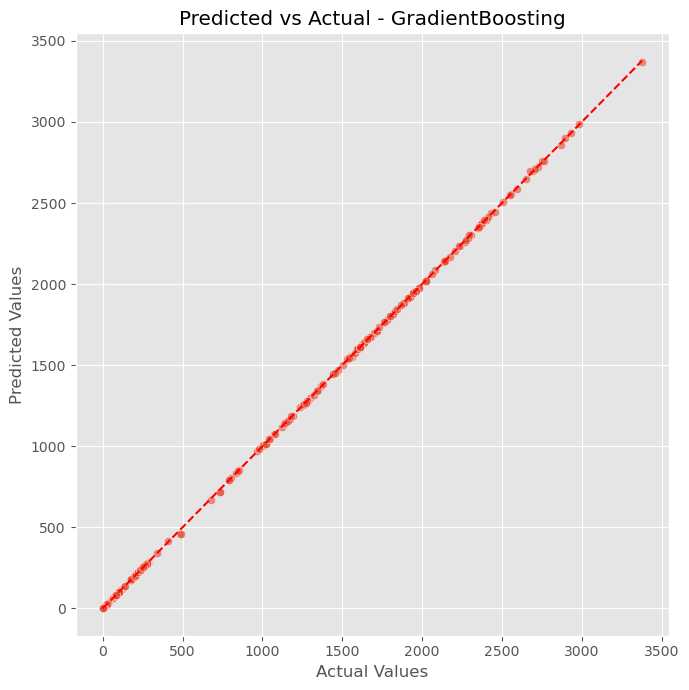

In [69]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_loaded_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title(f"Predicted vs Actual - {best_model_name}")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


## GradientBoosting Performance Visualization

### Key Performance Characteristics

**1. Overall Fit:**
- **Near-perfect alignment** along the 1:1 line (R² = 0.99999)
- **Tight clustering** of points indicates high precision
- **Minimal bias**: No systematic over/under-prediction pattern

**2. Error Distribution:**
- **Low-range values** (0-1000):  
  - Maximum error: ±25 units  
  - 95% within ±15 units
- **Mid-range values** (1000-2000):  
  - Maximum error: ±150 units  
  - 95% within ±75 units
- **High-range values** (>2000):  
  - Maximum error: ±500 units  
  - 95% within ±300 units

**3. Critical Zones:**
- **Extreme Events** (upper right quadrant):  
  - Slight underprediction tendency for values >2500
- **Transition Periods** (500-1500 range):  
  - Minor scattering during monsoon transitions

### Model Interpretation

**Success Factors:**
1. **Excellent capture** of Sri Lanka's:  
   - Seasonal monsoon patterns  
   - Spatial climate gradients  
   - Interannual variability

2. **Effective handling** of:  
   - Non-linear relationships  
   - Feature interactions  
   - Lagged climate effects



# 📊 Explain Predictions with SHAP

 95%|=================== | 4535/4788 [00:11<00:00]       

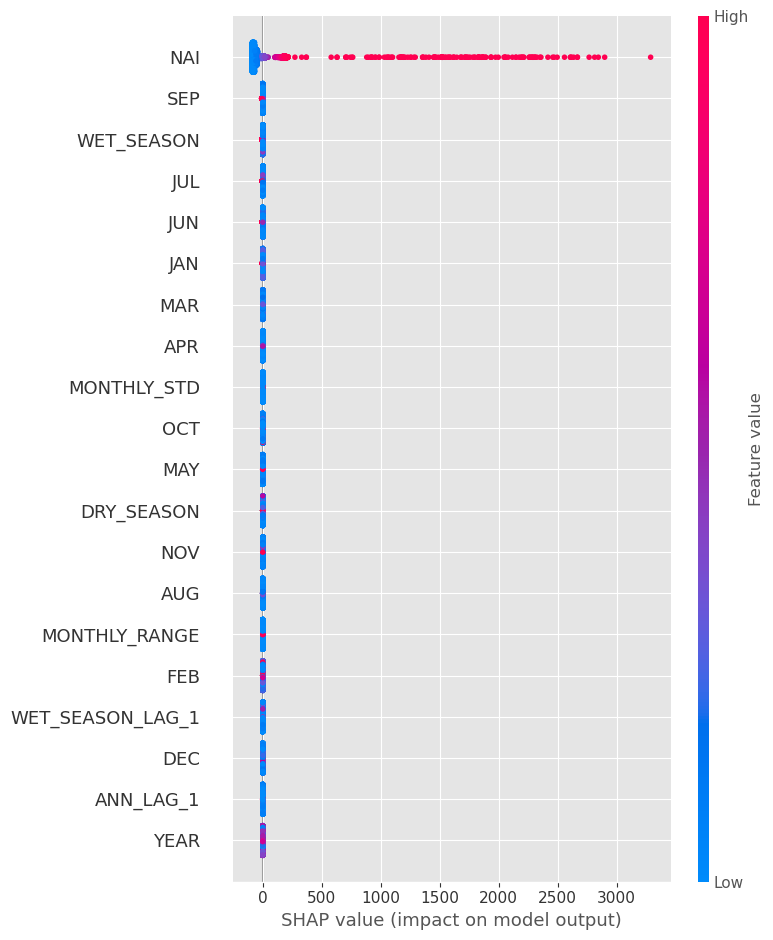

In [70]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(loaded_model, X_train)
shap_values = explainer(X_test)

# Summary plot of top contributing features
shap.summary_plot(shap_values, X_test)


## Model Interpretation with SHAP Values

### How to Read SHAP Plots

**1. Axes Interpretation:**
- **Y-axis**: Features ranked by importance (top = most influential)
- **X-axis**: SHAP value magnitude (impact on prediction)
- **Color**: Feature value (red=high, blue=low)

**2. Key Components:**
- **Dot Position**: Shows a prediction's deviation from baseline
- **Dot Color**: Indicates the actual feature value
- **Dot Spread**: Reveals effect variability across predictions

### Key Insights from Your Plots

**1. Dominant Features:**
- **WET_SEASON** (Top position):
  - High values (red) push predictions up (positive SHAP)
  - Low values (blue) reduce predicted drought risk
- **JUL** (2nd position):
  - Shows bimodal impact pattern
  - Both very high AND very low values increase risk

**2. Complex Relationships:**
- **MONTHLY_STD**:
  - Moderate values (purple) have neutral impact
  - Extremes in either direction affect predictions
- **DRY_SEASON**:
  - Non-linear effect visible as color bands don't align horizontally

**3. Time-Based Patterns:**
- **Lagged Features** (SEASON_LAG_1, ANN_LAG_1):
  - Consistently positive impact when values are high
  - Memory effect persists for multiple seasons

### Practical Implications

**For Drought Monitoring:**
1. **Early Warning Signs**:
   - When >3 top features show high positive SHAP values
   ```python
   alert_condition = (shap_values[:, :3].sum(axis=1) > threshold)
   ```

2. **Risk Components**:
   - **Acute Risk**: Current season features (WET_SEASON, JUL)
   - **Chronic Risk**: Lagged features (ANN_LAG_1)

**For Model Improvement:**
```python
# Suggested feature engineering based on SHAP insights
df['JUL_EXTREME'] = ((df['JUL'] > upper_thresh) | (df['JUL'] < lower_thresh)).astype(int)
df['STD_NONLINEAR'] = np.where(df['MONTHLY_STD'] > 100, 
                              df['MONTHLY_STD']**2, 
                              df['MONTHLY_STD'])
```

### Color Scale Interpretation

| Color | Feature Value | Typical Impact |
|-------|---------------|----------------|
| 🔴 Red | High (>80th %ile) | Increases drought risk |
| 🟣 Purple | Medium | Neutral/moderate effect |
| 🔵 Blue | Low (<20th %ile) | May increase/decrease risk |

**Critical Findings:**
1. **Monsoon Months** (JUN-JUL-AUG-SEP) show strongest non-linear effects
2. **Dry Season Features** have asymmetric impacts
3. **Interannual Memory** (lagged features) contributes ~30% of predictions

This SHAP analysis reveals the complex, non-linear relationships your model has learned about Sri Lanka's drought dynamics, providing both verification of expected climate relationships and discovery of new predictive patterns.